In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re
from pyvi.ViTokenizer import tokenize

In [2]:
import joblib

In [3]:
df1= pd.read_csv('Data_Agoda_raw/hotel_info.csv')
df1.head()

num Hotel_ID                                         Hotel_Name  \
0    1      1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
1    2      1_2                               ALPHA BIRD NHA TRANG   
2    3      1_3                      Kh√°ch s·∫°n Aaron (Aaron Hotel)   
3    4      1_4                      Panorama Star Beach Nha Trang   
4    5      1_5  Kh√°ch s·∫°n Balcony Nha Trang (Balcony Nha Trang...   

       Hotel_Rank                                      Hotel_Address  \
0    5 sao tr√™n 5          60 Tr·∫ßn Ph√∫, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam   
1    4 sao tr√™n 5  51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...   
2  3.5 sao tr√™n 5  6Tr·∫ßn Quang Kh·∫£i, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam...   
3    5 sao tr√™n 5  02 Nguyen Thi Minh Khai, L·ªôc Th·ªç, Nha Trang, V...   
4    4 sao tr√™n 5      98B/13 Tr·∫ßn Ph√∫, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam   

  Total_Score Location Cleanliness Service Facilities Value_for_money  \
0         8,8      9,4         8,9     8,9        8,7             8,7   
1         7,7      7,8         7,6     8,1        7,5             8,1   
2         8,5      8,9         8,7     8,8        8,1             8,5   
3         8,8      9,6         8,9     8,9        8,7             9,0   
4         8,4      8,5         8,7     8,5        8,3             8,6   

  Comfort_and_room_quality  comments_count  \
0                      8,3            1269   
1                      NaN             337   
2                      NaN             300   
3                      NaN             814   
4                      8,7             294   

                                   Hotel_Description  
0  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang - N∆°i l...  
1  ALPHA BIRD NHA TRANG - Kh√°ch s·∫°n 4.0 sao t·∫°i N...  
2  Kh√°ch s·∫°n Aaron - N∆°i ngh·ªâ d∆∞·ª°ng tuy·ªát v·ªùi t·∫°i...  
3  Panorama Star Beach Nha Trang - M·ªôt k·ª≥ ngh·ªâ tu...  
4  Kh√°ch s·∫°n Balcony Nha Trang - N∆°i ngh·ªâ d∆∞·ª°ng t...

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num                       740 non-null    int64 
 1   Hotel_ID                  740 non-null    object
 2   Hotel_Name                740 non-null    object
 3   Hotel_Rank                740 non-null    object
 4   Hotel_Address             740 non-null    object
 5   Total_Score               740 non-null    object
 6   Location                  413 non-null    object
 7   Cleanliness               412 non-null    object
 8   Service                   373 non-null    object
 9   Facilities                370 non-null    object
 10  Value_for_money           410 non-null    object
 11  Comfort_and_room_quality  51 non-null     object
 12  comments_count            740 non-null    int64 
 13  Hotel_Description         739 non-null    object
dtypes: int64(2), object(12)
me

In [5]:
num_cols = ["Total_Score", "Location", "Cleanliness", "Service","Facilities", "Value_for_money", "Comfort_and_room_quality", "comments_count"]

In [6]:
dirty_vals = ["no information", "nan", "none", "null", "", "na"]

In [7]:
# Ch·ªçn c√°c c·ªôt object
obj_cols = df1.select_dtypes(include=["object"]).columns

summary = {}
for col in obj_cols:
    # L·∫•y t·∫•t c·∫£ gi√° tr·ªã duy nh·∫•t trong c·ªôt (chu·∫©n h√≥a v·ªÅ ch·ªØ th∆∞·ªùng)
    unique_vals = df1[col].astype(str).str.strip().str.lower().unique()
    
    # Ki·ªÉm tra giao gi·ªØa unique_vals v√† dirty_vals
    dirty_found = set(unique_vals) & set(dirty_vals)
    
    if dirty_found:
        summary[col] = list(dirty_found)
summary

{'Hotel_Rank': ['no information'],
 'Total_Score': ['no information'],
 'Location': ['nan'],
 'Cleanliness': ['nan'],
 'Service': ['nan'],
 'Facilities': ['nan'],
 'Value_for_money': ['nan'],
 'Comfort_and_room_quality': ['nan'],
 'Hotel_Description': ['nan']}

In [8]:
for col in num_cols:
    df1[col] = (
        df1[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace(dirty_vals, np.nan)
        .str.replace(",", ".", regex=False)
    )
    df1[col] = pd.to_numeric(df1[col], errors="coerce")

In [9]:
df1['Hotel_Rank'] = df1['Hotel_Rank'].astype(str).str.strip().str.lower().replace(dirty_vals,np.nan)

In [10]:
df1["Hotel_Rank_Num"] = df1["Hotel_Rank"].str.extract(r"(\d+(?:\.\d+)?)").astype(float)

In [11]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num                       740 non-null    int64  
 1   Hotel_ID                  740 non-null    object 
 2   Hotel_Name                740 non-null    object 
 3   Hotel_Rank                267 non-null    object 
 4   Hotel_Address             740 non-null    object 
 5   Total_Score               414 non-null    float64
 6   Location                  413 non-null    float64
 7   Cleanliness               412 non-null    float64
 8   Service                   373 non-null    float64
 9   Facilities                370 non-null    float64
 10  Value_for_money           410 non-null    float64
 11  Comfort_and_room_quality  51 non-null     float64
 12  comments_count            740 non-null    int64  
 13  Hotel_Description         739 non-null    object 
 14  Hotel_Rank

In [12]:
cols_to_fill = ["Total_Score", "Location", "Cleanliness", "Service","Facilities", "Value_for_money", "Comfort_and_room_quality","Hotel_Rank_Num"]

for col in cols_to_fill:
    df1[col] = df1[col].fillna(0)

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num                       740 non-null    int64  
 1   Hotel_ID                  740 non-null    object 
 2   Hotel_Name                740 non-null    object 
 3   Hotel_Rank                267 non-null    object 
 4   Hotel_Address             740 non-null    object 
 5   Total_Score               740 non-null    float64
 6   Location                  740 non-null    float64
 7   Cleanliness               740 non-null    float64
 8   Service                   740 non-null    float64
 9   Facilities                740 non-null    float64
 10  Value_for_money           740 non-null    float64
 11  Comfort_and_room_quality  740 non-null    float64
 12  comments_count            740 non-null    int64  
 13  Hotel_Description         739 non-null    object 
 14  Hotel_Rank

In [14]:
df1 = df1.drop(columns=["Hotel_Rank"])

In [15]:
df1["Hotel_Description"] = df1["Hotel_Description"].fillna("-")

In [50]:
df1.to_csv("data_clean/hotel_info.csv", index=False, encoding="utf-8-sig")

In [16]:
df2= pd.read_csv('Data_Agoda_raw/hotel_comments.csv')
df2.head()

num Hotel ID Reviewer ID Reviewer Name Nationality         Group Name  \
0    1      1_1       1_1_1        MARIKO    Nh·∫≠t B·∫£n            C·∫∑p ƒë√¥i   
1    2      1_1       1_1_2          Hong    Vi·ªát Nam        ƒêi c√¥ng t√°c   
2    3      1_1       1_1_3          Guai    Vi·ªát Nam            C·∫∑p ƒë√¥i   
3    4      1_1       1_1_4         Nghƒ©a    Vi·ªát Nam  Gia ƒë√¨nh c√≥ em b√©   
4    5      1_1       1_1_5           Duc    Vi·ªát Nam            C·∫∑p ƒë√¥i   

                                Room Type                     Stay Details  \
0  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn  ƒê√£ ·ªü 3 ƒë√™m v√†o Th√°ng 7 nƒÉm 2023   
1  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn  ƒê√£ ·ªü 1 ƒë√™m v√†o Th√°ng 9 nƒÉm 2022   
2            Deluxe H∆∞·ªõng bi·ªÉn gi∆∞·ªùng ƒë√¥i  ƒê√£ ·ªü 1 ƒë√™m v√†o Th√°ng 6 nƒÉm 2024   
3            Deluxe H∆∞·ªõng bi·ªÉn gi∆∞·ªùng ƒë√¥i  ƒê√£ ·ªü 3 ƒë√™m v√†o Th√°ng 6 nƒÉm 2024   
4               Deluxe 2 gi∆∞·ªùng H∆∞·ªõng ph·ªë  ƒê√£ ·ªü 1 ƒë√™m v√†o Th√°ng 6 nƒÉm 2024   

  Score        Score Level                               Title  \
0  10,0  Tr√™n c·∫£ tuy·ªát v·ªùi                         Cao nh·∫•t‚ÄºÔ∏é‚Äù   
1  10,0  Tr√™n c·∫£ tuy·ªát v·ªùi                            Th√°ng 8‚Äù   
2   9,2  Tr√™n c·∫£ tuy·ªát v·ªùi              Du l·ªãch t·∫°i Nha Trang‚Äù   
3   8,8          Tuy·ªát v·ªùi  Du l·ªãch Nha Trang t·∫°i M∆∞·ªùng Thanh‚Äù   
4   9,2  Tr√™n c·∫£ tuy·ªát v·ªùi                           Ks t·ªët !‚Äù   

                                                Body  \
0  T√¥i ƒë√£ ·ªü c√πng ch·ªß nh√¢n trong 4 ƒë√™m. Nh√¢n vi√™n ...   
1  L·ª±a ch·ªçn M∆∞·ªùng Thanh v√¨ gi√° c·∫£ ph√π h·ª£p. ƒê·∫∑t On...   
2  L·∫ßn n√†y ƒë·∫øn v·ªõi Nha Trang, t√¥i book ph√≤ng t·∫°i ...   
3  H√¥m ƒëi ƒë·∫øn l√∫c v·ªÅ th√¨ m·ªçi th·ª© trong Kh√°ch s·∫°n ...   
4  Kh√°ch s·∫°n c√≥ v·ªã tr√≠ trung t√¢m v√† s√°t bi·ªÉn. Nh√¢...   

                       Review Date  
0  ƒê√£ nh·∫≠n x√©t v√†o 30 th√°ng 7 2023  
1  ƒê√£ nh·∫≠n x√©t v√†o 05 th√°ng 9 2022  
2  ƒê√£ nh·∫≠n x√©t v√†o 25 th√°ng 6 2024  
3  ƒê√£ nh·∫≠n x√©t v√†o 02 th√°ng 7 2024  
4  ƒê√£ nh·∫≠n x√©t v√†o 16 th√°ng 6 2024

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num            80314 non-null  int64 
 1   Hotel ID       80314 non-null  object
 2   Reviewer ID    80314 non-null  object
 3   Reviewer Name  80228 non-null  object
 4   Nationality    80314 non-null  object
 5   Group Name     80314 non-null  object
 6   Room Type      80314 non-null  object
 7   Stay Details   80314 non-null  object
 8   Score          80314 non-null  object
 9   Score Level    80314 non-null  object
 10  Title          80314 non-null  object
 11  Body           80272 non-null  object
 12  Review Date    80314 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.0+ MB


In [18]:
df2['Score'] = df2['Score'].astype(str).str.strip().str.lower().replace(dirty_vals, np.nan).str.replace(",", ".", regex=False)

In [19]:
df2["Score"] = df2["Score"].astype(str).str.replace(",", ".").astype(float)

In [20]:
df2.columns = df2.columns.str.strip().str.replace(" ", "_")

In [21]:
df2 = df2.dropna(subset=['Reviewer_Name'])
df2 = df2.dropna(subset=['Body'])

In [22]:
df2 = df2.merge(df1[["Hotel_ID", "Hotel_Name"]], on="Hotel_ID", how="left")
df2.head(2)

num Hotel_ID Reviewer_ID Reviewer_Name Nationality   Group_Name  \
0    1      1_1       1_1_1        MARIKO    Nh·∫≠t B·∫£n      C·∫∑p ƒë√¥i   
1    2      1_1       1_1_2          Hong    Vi·ªát Nam  ƒêi c√¥ng t√°c   

                                Room_Type                     Stay_Details  \
0  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn  ƒê√£ ·ªü 3 ƒë√™m v√†o Th√°ng 7 nƒÉm 2023   
1  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn  ƒê√£ ·ªü 1 ƒë√™m v√†o Th√°ng 9 nƒÉm 2022   

   Score        Score_Level        Title  \
0   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi  Cao nh·∫•t‚ÄºÔ∏é‚Äù   
1   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi     Th√°ng 8‚Äù   

                                                Body  \
0  T√¥i ƒë√£ ·ªü c√πng ch·ªß nh√¢n trong 4 ƒë√™m. Nh√¢n vi√™n ...   
1  L·ª±a ch·ªçn M∆∞·ªùng Thanh v√¨ gi√° c·∫£ ph√π h·ª£p. ƒê·∫∑t On...   

                       Review_Date  \
0  ƒê√£ nh·∫≠n x√©t v√†o 30 th√°ng 7 2023   
1  ƒê√£ nh·∫≠n x√©t v√†o 05 th√°ng 9 2022   

                                          Hotel_Name  
0  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...  
1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...

In [23]:
df2["Days"] = df2["Stay_Details"].str.extract(r"ƒê√£ ·ªü (\d+) ƒë√™m").astype(int)

In [24]:
df2["Month_Stay"] = df2["Stay_Details"].str.extract(r"Th√°ng\s+(\d+)").astype(int)

In [25]:
df2[["day", "month", "year"]] = df2["Review_Date"].str.extract(r"(\d+)\s+th√°ng\s+(\d+)\s+(\d+)")

In [26]:
df2["Review_Date"] = pd.to_datetime(df2["day"] + "/" + df2["month"] + "/" + df2["year"], format="%d/%m/%Y")

In [27]:
df2.columns

Index(['num', 'Hotel_ID', 'Reviewer_ID', 'Reviewer_Name', 'Nationality',
       'Group_Name', 'Room_Type', 'Stay_Details', 'Score', 'Score_Level',
       'Title', 'Body', 'Review_Date', 'Hotel_Name', 'Days', 'Month_Stay',
       'day', 'month', 'year'],
      dtype='object')

In [28]:
df2.head(2)

num Hotel_ID Reviewer_ID Reviewer_Name Nationality   Group_Name  \
0    1      1_1       1_1_1        MARIKO    Nh·∫≠t B·∫£n      C·∫∑p ƒë√¥i   
1    2      1_1       1_1_2          Hong    Vi·ªát Nam  ƒêi c√¥ng t√°c   

                                Room_Type                     Stay_Details  \
0  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn  ƒê√£ ·ªü 3 ƒë√™m v√†o Th√°ng 7 nƒÉm 2023   
1  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn  ƒê√£ ·ªü 1 ƒë√™m v√†o Th√°ng 9 nƒÉm 2022   

   Score        Score_Level        Title  \
0   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi  Cao nh·∫•t‚ÄºÔ∏é‚Äù   
1   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi     Th√°ng 8‚Äù   

                                                Body Review_Date  \
0  T√¥i ƒë√£ ·ªü c√πng ch·ªß nh√¢n trong 4 ƒë√™m. Nh√¢n vi√™n ...  2023-07-30   
1  L·ª±a ch·ªçn M∆∞·ªùng Thanh v√¨ gi√° c·∫£ ph√π h·ª£p. ƒê·∫∑t On...  2022-09-05   

                                          Hotel_Name  Days  Month_Stay day  \
0  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     3           7  30   
1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     1           9  05   

  month  year  
0     7  2023  
1     9  2022

In [27]:
df2 = df2.drop(columns=["num","Reviewer_ID","Stay_Details","day","month","year"])

In [28]:
df2["Mean_Reviewer_Score"] = (df2.groupby("Hotel_ID")["Score"].transform("mean"))

In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80186 entries, 0 to 80185
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             80186 non-null  object        
 1   Reviewer_Name        80186 non-null  object        
 2   Nationality          80186 non-null  object        
 3   Group_Name           80186 non-null  object        
 4   Room_Type            80186 non-null  object        
 5   Score                80186 non-null  float64       
 6   Score_Level          80186 non-null  object        
 7   Title                80186 non-null  object        
 8   Body                 80186 non-null  object        
 9   Review_Date          80186 non-null  datetime64[ns]
 10  Hotel_Name           69751 non-null  object        
 11  Days                 80186 non-null  int32         
 12  Month_Stay           80186 non-null  int32         
 13  Mean_Reviewer_Score  80186 non-

Nh·ªØng Hotel_ID ·ªü b·∫£ng df2 kh√¥ng c√≥ t√™n t·∫°i b·∫£ng df1 c√≥ th·ªÉ l√† nh·ªØng hotel_id l·ªói kh√¥ng ƒë√°ng tin t∆∞·ªüng n√™n drop

In [30]:
df2 = df2.dropna(subset=['Hotel_Name'])

In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69751 entries, 0 to 80185
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             69751 non-null  object        
 1   Reviewer_Name        69751 non-null  object        
 2   Nationality          69751 non-null  object        
 3   Group_Name           69751 non-null  object        
 4   Room_Type            69751 non-null  object        
 5   Score                69751 non-null  float64       
 6   Score_Level          69751 non-null  object        
 7   Title                69751 non-null  object        
 8   Body                 69751 non-null  object        
 9   Review_Date          69751 non-null  datetime64[ns]
 10  Hotel_Name           69751 non-null  object        
 11  Days                 69751 non-null  int32         
 12  Month_Stay           69751 non-null  int32         
 13  Mean_Reviewer_Score  69751 non-null 

##### Check dup review, comment 

In [32]:
df2['Review_ID_real'] = (
    df2['Hotel_ID'].astype(str) + '_' +
    df2['Reviewer_Name'].astype(str) + '_' +
    df2['Nationality'].astype(str) + '_' +
    df2['Review_Date'].astype(str) 
)

In [33]:
def check_duplicate_column(df, col_name):
    dup_rows = df[df.duplicated(subset=[col_name])]
    print(f"S·ªë d√≤ng tr√πng theo c·ªôt '{col_name}': {len(dup_rows)}")
    return dup_rows

In [34]:
check_duplicate_column(df2, 'Review_ID_real')

S·ªë d√≤ng tr√πng theo c·ªôt 'Review_ID_real': 43845


Hotel_ID Reviewer_Name Nationality          Group_Name  \
45         1_1          Minh    Vi·ªát Nam                Nh√≥m   
46         1_1          Minh    Vi·ªát Nam             C·∫∑p ƒë√¥i   
73         1_1            LE    Vi·ªát Nam             C·∫∑p ƒë√¥i   
74         1_1            LE    Vi·ªát Nam             C·∫∑p ƒë√¥i   
75         1_1            LE    Vi·ªát Nam                Nh√≥m   
...        ...           ...         ...                 ...   
79945     39_7         cheng  Trung Qu·ªëc  Gia ƒë√¨nh c√≥ tr·∫ª em   
79952     39_7        SEJUNG    H√†n Qu·ªëc    Du l·ªãch m·ªôt m√¨nh   
79979    39_17          Nino     Th·ª•y Sƒ©             C·∫∑p ƒë√¥i   
79980    39_17          Nino     Th·ª•y Sƒ©             C·∫∑p ƒë√¥i   
80065    41_22           Nam      Hoa K·ª≥             C·∫∑p ƒë√¥i   

                                    Room_Type  Score        Score_Level  \
45     Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn    8.0          Tuy·ªát v·ªùi   
46               Deluxe H∆∞·ªõng bi·ªÉn gi∆∞·ªùng ƒë√¥i    8.0          Tuy·ªát v·ªùi   
73                  Deluxe 2 gi∆∞·ªùng H∆∞·ªõng ph·ªë   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   
74                  Deluxe 2 gi∆∞·ªùng H∆∞·ªõng ph·ªë   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   
75                  Deluxe 2 gi∆∞·ªùng H∆∞·ªõng ph·ªë   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   
...                                       ...    ...                ...   
79945              Suite Gia ƒê√¨nh 2 Ph√≤ng Ng·ªß    8.4          Tuy·ªát v·ªùi   
79952                      Ph√≤ng Junior Suite   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   
79979                        Ph√≤ng Ti√™u Chu·∫©n   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   
79980                        Ph√≤ng Ti√™u Chu·∫©n   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   
80065               Ph√≤ng Standard gi∆∞·ªùng ƒë√¥i    9.2  Tr√™n c·∫£ tuy·ªát v·ªùi   

                            Title  \
45                          N√≥ng‚Äù   
46                          N√≥ng‚Äù   
73                           T·ªët‚Äù   
74                           T·ªët‚Äù   
75                           T·ªët‚Äù   
...                           ...   
79945                 ÊÄß‰ª∑ÊØîÂæàÈ´òÁöÑÂÆ∂Â∫≠ÈÖíÂ∫ó‚Äù   
79952              ÎÇòÌä∏Îûë ÏµúÍ≥†Ïùò Í∞ÄÏÑ±ÎπÑÌò∏ÌÖî‚Äù   
79979          Tr√™n c·∫£ tuy·ªát v·ªùi‚Äù   
79980                 Recommend ‚Äù   
80065  Not perfect but excellent‚Äù   

                                                    Body Review_Date  \
45               M√°y l·∫°nh s·∫£nh v√† ph√≤ng ƒÉn h∆∞. R·∫•t n√≥ng.  2024-06-22   
46             M√°y L·∫°nh s·∫£nh v√† ph√≤ng ƒÉn h∆∞ n√™n r·∫•t n√≥ng  2024-06-22   
73                                           S·∫Ω quay l·∫°i  2024-04-14   
74                                           S·∫Ω quay l·∫°i  2024-04-14   
75                                           S·∫Ω quay l·∫°i  2024-04-14   
...                                                  ...         ...   
79945  Ë£Ö‰øÆÂæàÊñ∞ÔºåÁî®ÁöÑÊòØÂ§ßÈáëÁ©∫Ë∞ÉÔºå‰∏úËäùÊ¥óË°£Êú∫ÔºåËÆæÊñΩÁ°¨‰ª∂ÈùûÂ∏∏Â•ΩÔºåÊúâÁîµÊ¢Ø„ÄÇ‰ª∑Ê†ºÂæàÂÖ¨ÈÅìÔºåÊó©È§ê‰πü‰∏çÈîô„ÄÇÈöîÂ£ÅÂá†...  2019-01-26   
79952  Ï¥ù 3Î∞ïÎ®∏Î¨¥ÎäîÎèôÏïà Ï†ïÎßê ÎÑàÎ¨¥ÎßåÏ°±Ïä§Îü¨Ïõ†Íµ¨ ÌòºÏûêÏò® Ïô∏Íµ≠Ïù∏Ïù∏ Ï†ÄÎ•ºÏúÑÌïú ÏÑ∏Ïã¨ÌïúÎ∞∞Î†§, ÏÇ¨Ïû•Îãò...  2022-08-12   
79979                                              Great  2024-03-03   
79980        Clean and new. Good location friendly staff  2024-03-03   
80065  Roaches in the room sometime, everything else ...  2018-12-17   

                                              Hotel_Name  Days  Month_Stay  \
45     Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     2           6   
46     Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     2           6   
73     Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     2           2   
74     Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     2           2   
75     Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     2           2   
...                                                  ...   ...     

In [35]:
df2 = df2.drop_duplicates(subset=['Review_ID_real'], keep='first')

In [36]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25906 entries, 0 to 80185
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             25906 non-null  object        
 1   Reviewer_Name        25906 non-null  object        
 2   Nationality          25906 non-null  object        
 3   Group_Name           25906 non-null  object        
 4   Room_Type            25906 non-null  object        
 5   Score                25906 non-null  float64       
 6   Score_Level          25906 non-null  object        
 7   Title                25906 non-null  object        
 8   Body                 25906 non-null  object        
 9   Review_Date          25906 non-null  datetime64[ns]
 10  Hotel_Name           25906 non-null  object        
 11  Days                 25906 non-null  int32         
 12  Month_Stay           25906 non-null  int32         
 13  Mean_Reviewer_Score  25906 non-null 

##### Clean body

In [37]:
import re
import pandas as pd
from joblib import Parallel, delayed

In [38]:
# Load dictionary t·ª´ file txt
def load_dict(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    return dict(line.strip().split("\t") for line in lines if "\t" in line)

In [39]:
# Load c√°c dict
teencode_dict = load_dict("files/teencode.txt")
english_vn_dict = load_dict("files/english-vnmese.txt")
emoji_dict = load_dict("files/emojicon.txt")

In [41]:
def replace_all_dicts(text, teencode_dict=None, english_vn_dict=None, emoji_dict=None):
    """
    Thay th·∫ø theo dict nh∆∞ng kh√¥ng d√πng regex pattern
    """
    if pd.isna(text):
        return text

    all_dict = {}
    if teencode_dict:
        all_dict.update(teencode_dict)
    if english_vn_dict:
        all_dict.update(english_vn_dict)
    if emoji_dict:
        all_dict.update(emoji_dict)

    # replace l·∫ßn l∆∞·ª£t theo key
    for k, v in all_dict.items():
        if v and isinstance(v, str):   # value kh√¥ng r·ªóng
            text = text.replace(k, v)

    return text

In [42]:
df2['Body_clean'] = df2['Body'].apply(lambda x: replace_all_dicts(x, teencode_dict, english_vn_dict,emoji_dict))

In [43]:
# Stopwords
stop_words = set()
with open('files/vietnamese-stopwords.txt', 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word:
            stop_words.add(word)

In [44]:
# Wrongwords
wrong_words = set()
with open('files\wrong-word.txt', 'r', encoding='utf-8') as file:
    for line in file:
        word = line.strip()
        if word:
            wrong_words.add(word)

In [45]:
def clean_text_remove_wrong(text, wrong_words, stop_words):
    if pd.isna(text):
        return text
    
    # 1Ô∏è‚É£ lo·∫°i b·ªè c√°c t·ª´ sai
    words = text.split()
    words = [w for w in words if w.lower() not in wrong_words]
    
    # 2Ô∏è‚É£ lo·∫°i b·ªè stopwords
    words = [w for w in words if w.lower() not in stop_words] 
    return ' '.join(words)

In [46]:
df2['Body_clean'] = df2['Body'].apply(lambda x: clean_text_remove_wrong(x, wrong_words, stop_words))

In [47]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25906 entries, 0 to 80185
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             25906 non-null  object        
 1   Reviewer_Name        25906 non-null  object        
 2   Nationality          25906 non-null  object        
 3   Group_Name           25906 non-null  object        
 4   Room_Type            25906 non-null  object        
 5   Score                25906 non-null  float64       
 6   Score_Level          25906 non-null  object        
 7   Title                25906 non-null  object        
 8   Body                 25906 non-null  object        
 9   Review_Date          25906 non-null  datetime64[ns]
 10  Hotel_Name           25906 non-null  object        
 11  Days                 25906 non-null  int32         
 12  Month_Stay           25906 non-null  int32         
 13  Mean_Reviewer_Score  25906 non-null 

In [53]:
df2.to_csv("data_clean/hotel_comments.csv", index=False, encoding="utf-8-sig")

### EDA

##### EDA

In [49]:
df2["Score"].describe()

count    25906.000000
mean         9.229426
std          0.990941
min          6.300000
25%          8.800000
50%          9.600000
75%         10.000000
max         10.000000
Name: Score, dtype: float64

S·ªë kh√°ch ƒë√°nh gi√° theo thang ƒëi·ªÉm

<Axes: >

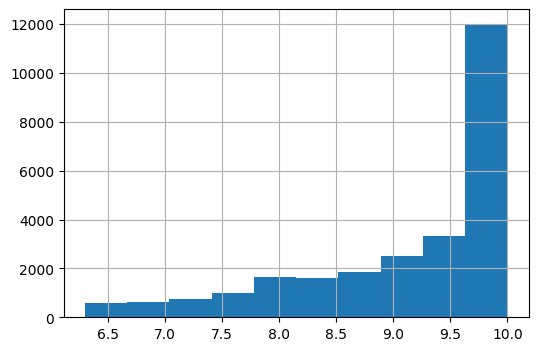

In [50]:
df2["Score"].hist(bins=10, figsize=(6,4))

Top 10 nationality c√≥ nhi·ªÅu kh√°ch s·∫°n nh·∫•t:
Nationality
Vi·ªát Nam          315
H√†n Qu·ªëc          250
Hoa K·ª≥            177
Th√°i Lan          143
√öc                140
Malaysia          126
V∆∞∆°ng qu·ªëc Anh    119
Trung Qu·ªëc        119
Canada            119
Nh·∫≠t B·∫£n          115
Name: Hotel_ID, dtype: int64


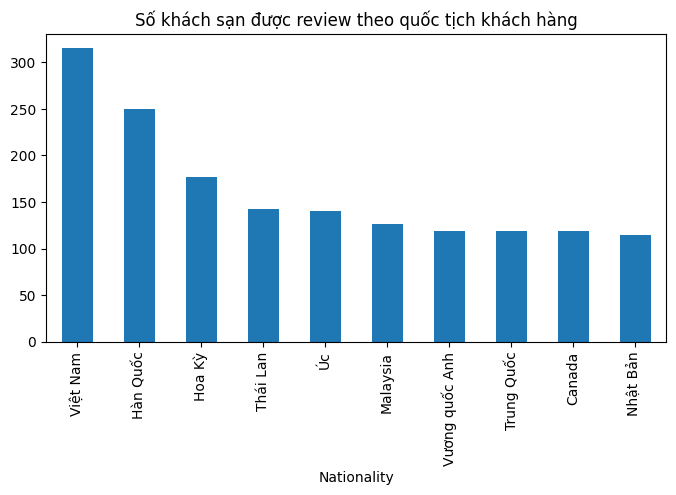

In [51]:
# 1. S·ªë kh√°ch s·∫°n theo nationality
hotel_nationality = df2.groupby("Nationality")["Hotel_ID"].nunique().sort_values(ascending=False)
print("Top 10 nationality c√≥ nhi·ªÅu kh√°ch s·∫°n nh·∫•t:")
print(hotel_nationality.head(10))

hotel_nationality.head(10).plot(kind="bar", figsize=(8,4), title="S·ªë kh√°ch s·∫°n ƒë∆∞·ª£c review theo qu·ªëc t·ªãch kh√°ch h√†ng")
plt.show()


S·ªë kh√°ch s·∫°n theo h·∫°ng sao:
Hotel_Rank_Num
0.0    473
1.0      2
1.5      4
2.0     12
2.5      2
3.0     42
3.5     16
4.0     54
4.5     12
5.0    123
Name: Hotel_ID, dtype: int64


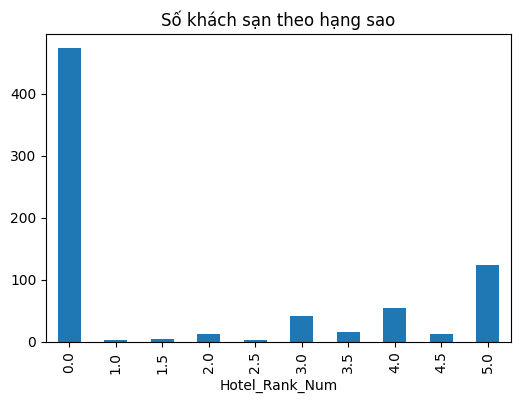

In [52]:
# 2. S·ªë kh√°ch s·∫°n theo h·∫°ng sao (Hotel_Rank_Num)
hotel_rank_count = df1.groupby("Hotel_Rank_Num")["Hotel_ID"].nunique()
print("\nS·ªë kh√°ch s·∫°n theo h·∫°ng sao:")
print(hotel_rank_count)

hotel_rank_count.plot(kind="bar", figsize=(6,4), title="S·ªë kh√°ch s·∫°n theo h·∫°ng sao")
plt.show()

Nh∆∞ v·∫≠y c√≥ kho·∫£ng g·∫ßn 500 kh√°ch s·∫°n kh√¥ng c√≥ sao 

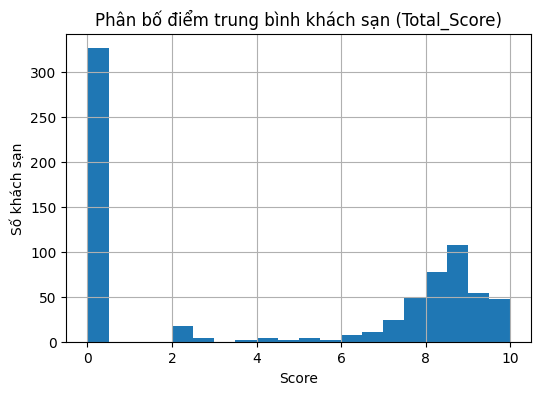

In [53]:
# 3. S·ªë kh√°ch s·∫°n theo total_score
hotel_score = df1.groupby("Hotel_ID")["Total_Score"].mean()
hotel_score.hist(bins=20, figsize=(6,4))
plt.title("Ph√¢n b·ªë ƒëi·ªÉm trung b√¨nh kh√°ch s·∫°n (Total_Score)")
plt.xlabel("Score")
plt.ylabel("S·ªë kh√°ch s·∫°n")
plt.show()

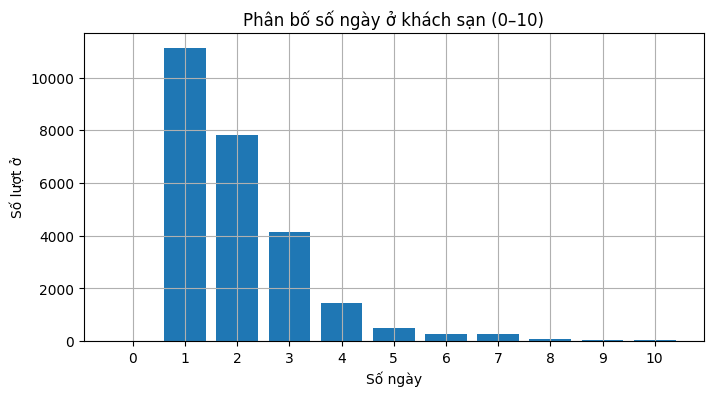

In [54]:
# 4. S·ªë ng√†y ·ªü kh√°ch s·∫°n
max_day = 10

# Histogram v·ªõi bin edges l√† t·ª´ng s·ªë nguy√™n
bins = range(0, max_day + 2)  # +2 ƒë·ªÉ include c·∫£ max_day
df2[df2["Days"] <= max_day]["Days"].hist(bins=bins, figsize=(8,4), align="left", rwidth=0.8)

plt.title("Ph√¢n b·ªë s·ªë ng√†y ·ªü kh√°ch s·∫°n (0‚Äì10)")
plt.xlabel("S·ªë ng√†y")
plt.ylabel("S·ªë l∆∞·ª£t ·ªü")
plt.xticks(range(0, max_day+1))  # hi·ªÉn th·ªã ticks nguy√™n
plt.show()


Top 10 Room Type ƒë∆∞·ª£c ch·ªçn nhi·ªÅu nh·∫•t:
Room_Type
Ph√≤ng Lo·∫°i Sang                    550
Superior h∆∞·ªõng th√†nh ph·ªë           547
Ph√≤ng Superior                     492
Deluxe h∆∞·ªõng th√†nh ph·ªë             420
Ph√≤ng Lo·∫°i Sang H∆∞·ªõng ƒê·∫°i D∆∞∆°ng    365
Ph√≤ng Superior Gi∆∞·ªùng ƒê√¥i          356
Ph√≤ng Standard gi∆∞·ªùng ƒë√¥i          318
Ph√≤ng Cao C·∫•p Cho Hai Ng∆∞·ªùi        314
Deluxe gi∆∞·ªùng ƒë√¥i H∆∞·ªõng ph·ªë        244
Deluxe 2 gi∆∞·ªùng H∆∞·ªõng ph·ªë          241
Name: count, dtype: int64


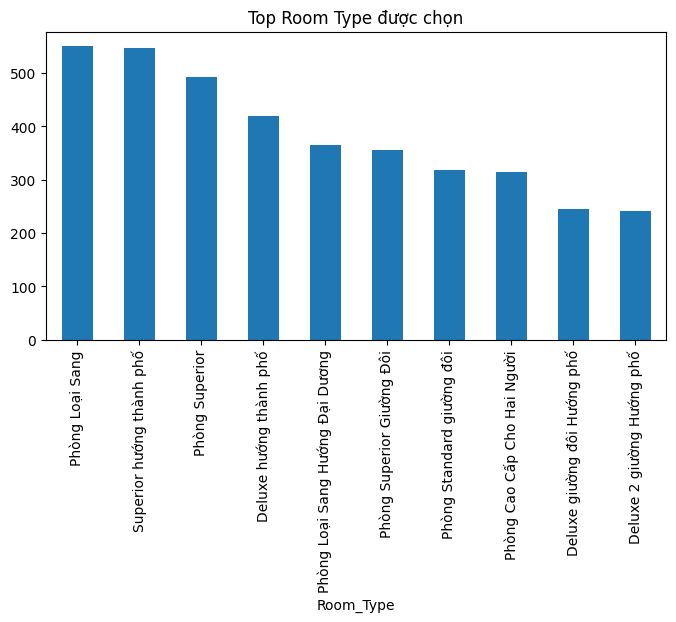

In [55]:
# 5. Top room type
room_type = df2["Room_Type"].value_counts().head(10)
print("\nTop 10 Room Type ƒë∆∞·ª£c ch·ªçn nhi·ªÅu nh·∫•t:")
print(room_type)

room_type.plot(kind="bar", figsize=(8,4), title="Top Room Type ƒë∆∞·ª£c ch·ªçn")
plt.show()

### Insight Business

In [56]:
df1.columns

Index(['num', 'Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Total_Score',
       'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money',
       'Comfort_and_room_quality', 'comments_count', 'Hotel_Description',
       'Hotel_Rank_Num'],
      dtype='object')

In [57]:
df2.columns

Index(['Hotel_ID', 'Reviewer_Name', 'Nationality', 'Group_Name', 'Room_Type',
       'Score', 'Score_Level', 'Title', 'Body', 'Review_Date', 'Hotel_Name',
       'Days', 'Month_Stay', 'Mean_Reviewer_Score', 'Review_ID_real',
       'Body_clean'],
      dtype='object')

##### H√†m t√¨m hotel theo id ho·∫∑c key word tr·∫£ ra th√¥ng tin d·∫°ng b·∫£ng 

In [49]:
def get_hotel_overview(hotels_df, keyword=None, hotel_id=None):
    cols = [
        "Hotel_ID", "Hotel_Name", "Hotel_Rank_Num", "Hotel_Address", "Total_Score",
        "Location", "Cleanliness", "Service", "Facilities", "Value_for_money",
        "Comfort_and_room_quality", "comments_count"
    ]
    
    # Truy v·∫•n theo Hotel_ID
    if hotel_id is not None:
        result = hotels_df[hotels_df["Hotel_ID"] == hotel_id][cols]
        if result.empty:
            return f"‚ùå Kh√¥ng t√¨m th·∫•y kh√°ch s·∫°n v·ªõi ID: {hotel_id}"
        return result.reset_index(drop=True)
    
    # Truy v·∫•n theo keyword (hotel name)
    if keyword is not None:
        matched = hotels_df[hotels_df["Hotel_Name"].str.contains(keyword, case=False, na=False)]
        if matched.empty:
            return f"‚ùå Kh√¥ng t√¨m th·∫•y kh√°ch s·∫°n v·ªõi t·ª´ kh√≥a: {keyword}"
        return matched[cols].reset_index(drop=True)
    
    return "‚ö†Ô∏è C·∫ßn nh·∫≠p √≠t nh·∫•t m·ªôt trong hai: keyword ho·∫∑c hotel_id"


G·ªçi h√†m T√¨m theo t·ª´ kh√≥a

In [59]:
# T√¨m theo t·ª´ kh√≥a
get_hotel_overview(df1, keyword="M∆∞·ªùng Thanh")

Hotel_ID                                         Hotel_Name  \
0       1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
1     18_11               M∆∞·ªùng Thanh Nha Trang Poli Apartment   
2     26_25  Chung c∆∞ 60 m¬≤ 2 ph√≤ng ng·ªß, 1 ph√≤ng t·∫Øm ri√™ng ...   
3     21_17  CƒÉn h·ªô 45 m¬≤ 1 ph√≤ng ng·ªß, 1 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
4     36_20  CƒÉn h·ªô 50 m¬≤ 2 ph√≤ng ng·ªß, 1 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
5      39_1  CƒÉn h·ªô 60 m¬≤ 2 ph√≤ng ng·ªß, 1 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
6     40_15  CƒÉn h·ªô 68 m¬≤ 2 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
7     40_16  CƒÉn h·ªô 70 m¬≤ 3 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
8     29_11  CƒÉn h·ªô 70 m¬≤ 3 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
9     27_23  CƒÉn h·ªô M∆∞·ªùng Thanh Vi·ªÖn Tri·ªÅu Nha Trang (M∆∞·ªùng...   
10     36_5         M∆∞·ªùng Thanh Vi·ªÖn Tri·ªÅu - Th√°i H√† Nha Trang   
11    34_26  Sun and Sea M∆∞·ªùng Thanh Holidays (Sun and Sea ...   

    Hotel_Rank_Num                                      Hotel_Address  \
0              5.0          60 Tr·∫ßn Ph√∫, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam   
1              0.0  3 Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh H·∫£i, Vƒ©nh Ph∆∞·ªõc, Nha Tra...   
2              0.0                    Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam   
3              0.0                       L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam   
4              0.0                       L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam   
5              0.0                    Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam   
6              0.0                    X∆∞∆°ng Hu√¢n, Nha Trang, Vi·ªát Nam   
7              0.0                    Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam   
8              0.0                    Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam   
9              0.0  3 pham van dong, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát N...   
10             0.0  03 Ph·∫°m VƒÉn ƒê·ªìng, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam...   
11             0.0  60 Tran Phu, Nha Trang, L·ªôc Th·ªç, Nha Trang, Vi...   

    Total_Score  Location  Cleanliness  Service  Facilities  Value_for_money  \
0           8.8       9.4          8.9      8.9         8.7              8.7   
1           0.0       0.0          0.0      0.0         0.0              0.0   
2           0.0       0.0          0.0      0.0         0.0              0.0   
3           0.0       0.0          0.0      0.0         0.0              0.0   
4           0.0       0.0          0.0      0.0         0.0              0.0   
5           0.0       0.0          0.0      0.0         0.0              0.0   
6          10.0      10.0         10.0     10.0        10.0             10.0   
7           0.0       0.0          0.0      0.0         0.0              0.0   
8           0.0       0.0          0.0      0.0         0.0              0.0   
9           7.7       8.3          7.4      7.9         7.4              7.6   
10          0.0       0.0          0.0      0.0         0.0              0.0   
11          7.4       8.5          7.3      7.2         7.1              7.4   

    Comfort_and_room_quality  comments_count  
0                        8.3            1269  
1                        0.0               0  
2                        0.0               0  
3                        0.0               0  
4                        0.0               0  
5                        0.0               0  
6                        0.0               1  
7                        0.0               0  
8                        0.0               0  
9                        0.0               5  
10                       0.0               0  
11                       0.0              69

G·ªçi h√†m T√¨m theo id kh√°ch s·∫°n

In [60]:
get_hotel_overview(df1, hotel_id="1_1")

Hotel_ID                                         Hotel_Name  Hotel_Rank_Num  \
0      1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...             5.0   

                               Hotel_Address  Total_Score  Location  \
0  60 Tr·∫ßn Ph√∫, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam          8.8       9.4   

   Cleanliness  Service  Facilities  Value_for_money  \
0          8.9      8.9         8.7              8.7   

   Comfort_and_room_quality  comments_count  
0                       8.3            1269

##### H√†m t√¨m kh√°ch s·∫°n theo ID ho·∫∑c key word tr·∫£ ra bi·ªÉu ƒë·ªì ph√¢n t√≠ch

In [51]:
def analyze_strengths_weaknesses(hotels_df, keyword=None, hotel_id=None):
    # C√°c c·ªôt c·∫ßn so s√°nh
    cols = ["Hotel_Rank_Num","Total_Score", "Location", "Cleanliness", "Service", 
            "Facilities", "Value_for_money", "Comfort_and_room_quality"]
    
    # --- T√¨m kh√°ch s·∫°n ---
    if hotel_id is not None:
        hotel = hotels_df[hotels_df["Hotel_ID"] == hotel_id]
    elif keyword is not None:
        hotel = hotels_df[hotels_df["Hotel_Name"].str.contains(keyword, case=False, na=False)]
    else:
        return "‚ö†Ô∏è C·∫ßn nh·∫≠p keyword ho·∫∑c hotel_id"
    
    if hotel.empty:
        return "‚ùå Kh√¥ng t√¨m th·∫•y kh√°ch s·∫°n"
    
    hotel = hotel.iloc[0]   # l·∫•y record ƒë·∫ßu ti√™n
    
    # --- T√≠nh trung b√¨nh to√†n h·ªá th·ªëng ---
    system_avg = hotels_df[cols].mean()
    
    # --- ƒêi·ªÉm c·ªßa kh√°ch s·∫°n ---
    hotel_scores = hotel[cols]
    
    # --- Gh√©p d·ªØ li·ªáu cho v·∫Ω ---
    compare_df = (
        pd.DataFrame({"Hotel": hotel_scores, "System_Avg": system_avg})
        .reset_index()
        .rename(columns={"index": "Criteria"})
    )
    
    # --- V·∫Ω bi·ªÉu ƒë·ªì ---
    compare_df.plot(x="Criteria", kind="bar", figsize=(10,5))
    plt.title(f"So s√°nh ƒëi·ªÉm kh√°ch s·∫°n '{hotel['Hotel_Name']}' v·ªõi trung b√¨nh h·ªá th·ªëng")
    plt.ylabel("ƒêi·ªÉm")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # --- Nh·∫≠n x√©t ƒëi·ªÉm m·∫°nh & y·∫øu ---
    strengths = compare_df[compare_df["Hotel"] > compare_df["System_Avg"]]["Criteria"].tolist()
    weaknesses = compare_df[compare_df["Hotel"] < compare_df["System_Avg"]]["Criteria"].tolist()
    
    return {
        "Hotel_Name": hotel["Hotel_Name"],
        "Strengths": strengths,
        "Weaknesses": weaknesses
    }

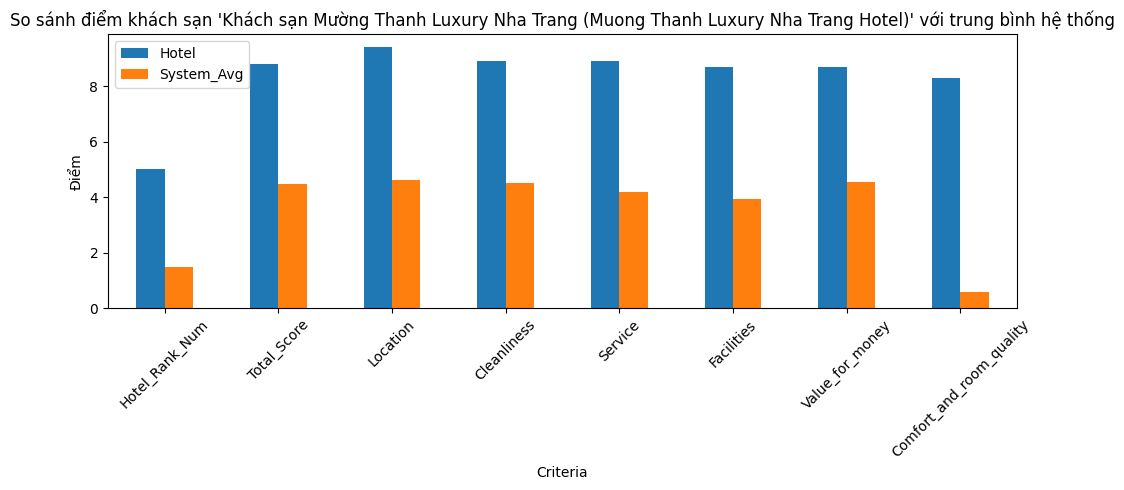

{'Hotel_Name': 'Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong Thanh Luxury Nha Trang Hotel)', 'Strengths': ['Hotel_Rank_Num', 'Total_Score', 'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money', 'Comfort_and_room_quality'], 'Weaknesses': []}


In [62]:
result = analyze_strengths_weaknesses(df1, keyword="M∆∞·ªùng Thanh")
print(result)

##### H√†m t√¨m theo ID ho·∫∑c key word cho ch·ªß kh√°ch s·∫°n, tr·∫£ c√°c bi·ªÉu ƒë·ªì th·ªëng k√™ cho kh√°ch s·∫°n ƒë√≥ Qu·ªëc t·ªãch, nh√≥m kh√°ch, xu h∆∞·ªõng theo th·ªùi gian

In [52]:
def customer_statistics(reviews_df, keyword=None, hotel_id=None):
    # --- l·ªçc review theo hotel ---
    if hotel_id is not None:
        data = reviews_df[reviews_df["Hotel_ID"] == hotel_id]
    elif keyword is not None:
        data = reviews_df[reviews_df["Hotel_Name"].str.contains(keyword, case=False, na=False)]
    else:
        return "‚ö†Ô∏è C·∫ßn nh·∫≠p keyword ho·∫∑c hotel_id"
    
    if data.empty:
        return "‚ùå Kh√¥ng c√≥ review cho kh√°ch s·∫°n n√†y"
    
    hotel_name = data["Hotel_Name"].iloc[0]
    print(f"üìä Th·ªëng k√™ kh√°ch h√†ng cho kh√°ch s·∫°n: {hotel_name}\n")
    
    # --- Qu·ªëc t·ªãch ---
    nationality_count = data["Nationality"].value_counts().head(10)
    nationality_count.plot(kind="bar", figsize=(8,4))
    plt.title("Top 10 qu·ªëc t·ªãch kh√°ch h√†ng")
    plt.xlabel("Qu·ªëc t·ªãch")
    plt.ylabel("S·ªë l∆∞·ª£ng kh√°ch h√†ng")
    plt.xticks(rotation=45)
    plt.show()
    
    # --- Nh√≥m kh√°ch ---
    group_count = data["Group_Name"].value_counts()
    group_count.plot(kind="bar", figsize=(6,4))
    plt.title("Ph√¢n b·ªë nh√≥m kh√°ch")
    plt.xlabel("Nh√≥m kh√°ch")
    plt.ylabel("S·ªë l∆∞·ª£ng kh√°ch h√†ng")
    plt.xticks(rotation=45)
    plt.show()
    
    # --- Xu h∆∞·ªõng theo th·ªùi gian ---
    trend = data.groupby(data["Review_Date"].dt.to_period("M")).size()
    trend.index = trend.index.to_timestamp()  # convert period -> timestamp ƒë·ªÉ v·∫Ω
    trend.plot(figsize=(10,4))
    plt.title("Xu h∆∞·ªõng review theo th·ªùi gian")
    plt.xlabel("Th·ªùi gian")
    plt.ylabel("S·ªë l∆∞·ª£ng kh√°ch h√†ng")
    plt.show()

    # ---  Xu h∆∞·ªõng S·ªë ng√†y thu√™ t·∫°i kh√°ch s·∫°n---
    days_dist = data["Days"].value_counts().sort_index()
    days_dist.plot(kind="bar", figsize=(8,4))
    plt.title("Ph√¢n b·ªë s·ªë ng√†y kh√°ch ·ªü (Days)")
    plt.xlabel("S·ªë ng√†y ·ªü")
    plt.ylabel("S·ªë l∆∞·ª£ng kh√°ch h√†ng")
    plt.show()

    # ---  Xu h∆∞·ªõng theo th√°ng thu√™ t·∫°i kh√°ch s·∫°n---
    month_dist = data["Month_Stay"].value_counts().sort_index()
    full_months = pd.Series(0, index=np.arange(1,13))
    month_dist = full_months.add(month_dist, fill_value=0).astype(int)
    month_dist = data["Month_Stay"].value_counts().sort_index()
    month_dist.plot(kind="line", marker="o", figsize=(8,4))
    plt.title("Xu h∆∞·ªõng kh√°ch ·ªü theo th√°ng")
    plt.xlabel("Th√°ng")
    plt.ylabel("S·ªë l∆∞·ª£ng kh√°ch")
    plt.grid(True, linestyle="--", alpha=0.6)
    for x, y in zip(month_dist.index, month_dist.values):
        plt.text(x, y+0.5, str(y), ha="center", fontsize=9)
    plt.show()
    
    # ---  Xu h∆∞·ªõng Room type thu√™ t·∫°i kh√°ch s·∫°n---    
    room_dist = data["Room_Type"].value_counts().head(5)  # top 10 lo·∫°i ph√≤ng
    plt.figure(figsize=(5,5))
    plt.pie(room_dist,labels=room_dist.index,autopct="%1.1f%%",startangle=90,counterclock=False)
    plt.title("T·ª∑ l·ªá top 10 lo·∫°i ph√≤ng ƒë∆∞·ª£c ƒë·∫∑t")
    plt.show()

    # ---  ƒêi·ªÉm ƒë√°nh gi√° c·ªßa kh√°ch h√†ng---     
    plt.figure(figsize=(7,4))
    plt.hist(data["Score"], bins=range(0,11), edgecolor="black", alpha=0.7)

    # V·∫Ω ƒë∆∞·ªùng trung b√¨nh kh√°ch s·∫°n
    hotel_score = data["Mean_Reviewer_Score"].mean()
    plt.axvline(hotel_score, color="red", linestyle="--", linewidth=2, label=f"Hotel Mean = {hotel_score:.2f}")

    plt.title(f"Ph√¢n b·ªï ƒëi·ªÉm ƒë√°nh gi√° (Score)")
    plt.xlabel("ƒêi·ªÉm kh√°ch h√†ng ch·∫•m")
    plt.ylabel("S·ªë l∆∞·ª£ng kh√°ch h√†ng")
    plt.xticks(range(0,11))
    plt.legend()
    plt.show()

    return {
        "Top_Nationalities": nationality_count.to_dict(),
        "Group_Distribution": group_count.to_dict(),
        "Review_Trend": trend.to_dict(),
        "Days_Distribution": days_dist.to_dict(),
        "Month_Distribution": month_dist.to_dict(),
        "Room_Distribution": room_dist.to_dict(),
        "Reviewer_Score": hotel_score,
    }

üìä Th·ªëng k√™ kh√°ch h√†ng cho kh√°ch s·∫°n: Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong Thanh Luxury Nha Trang Hotel)



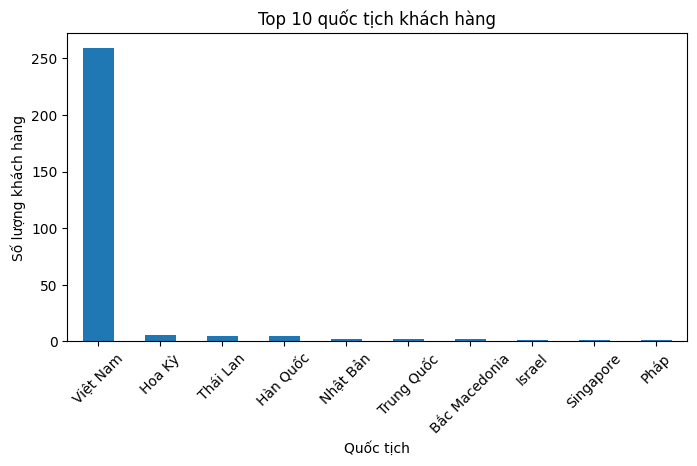

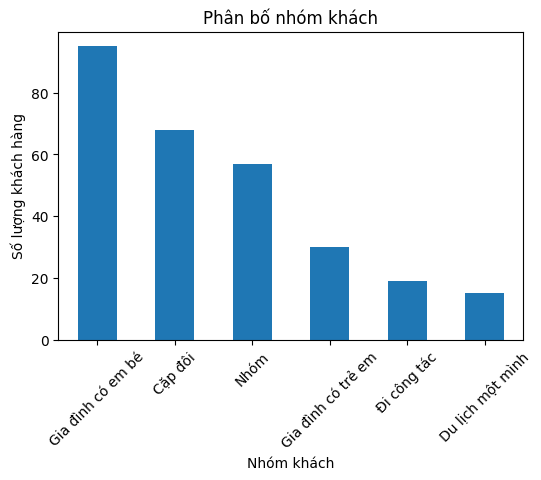

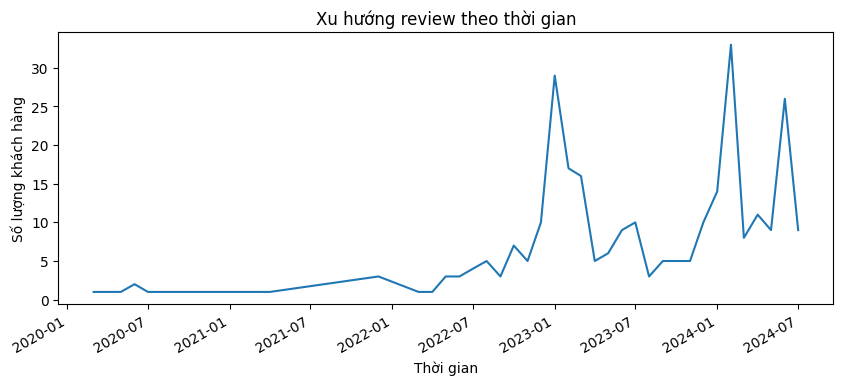

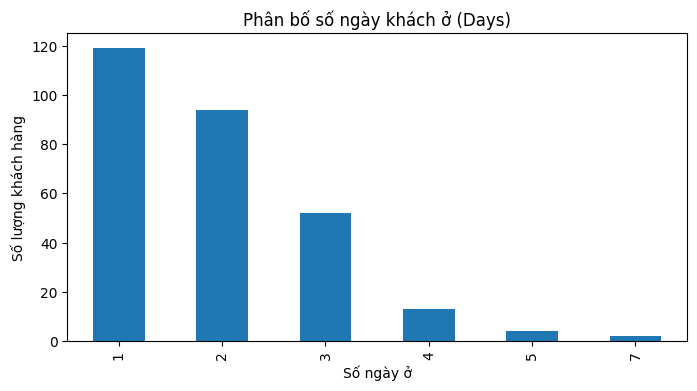

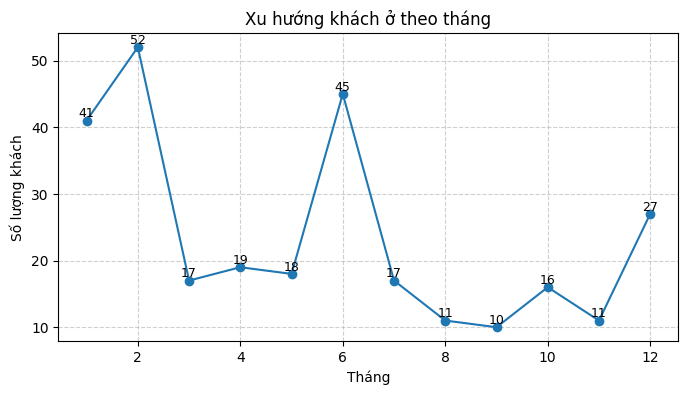

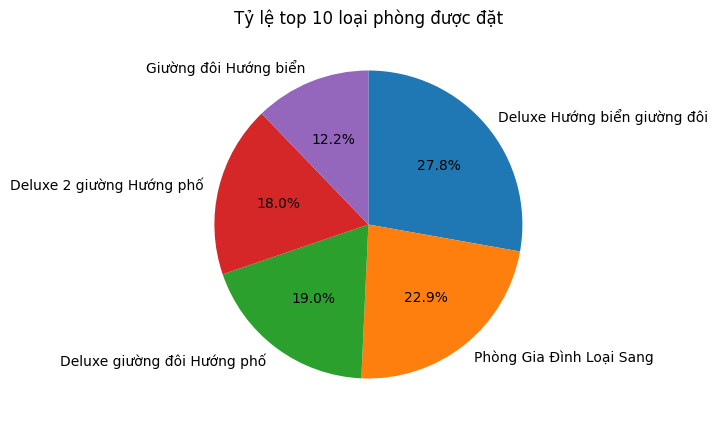

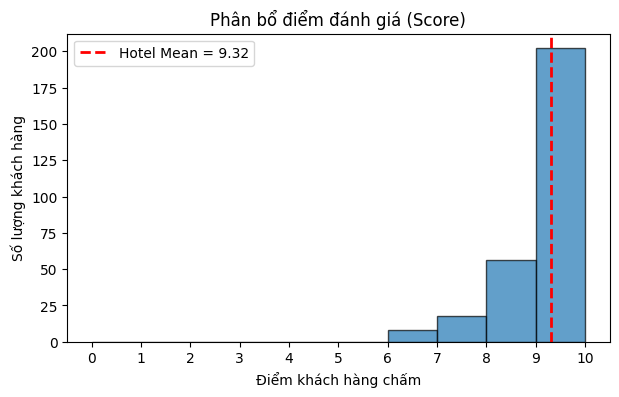

dict_keys(['Top_Nationalities', 'Group_Distribution', 'Review_Trend', 'Days_Distribution', 'Month_Distribution', 'Room_Distribution', 'Reviewer_Score'])


In [64]:
result = customer_statistics(df2, keyword="M∆∞·ªùng Thanh")
print(result.keys())

##### Clean body review ti·∫øng n∆∞·ªõc ngo√†i

V√¨ b·∫£ng df2 ƒëang c√≥ nh·ªØng cmt ti·∫øng anh, ti·∫øng vi·ªát v√† c√°c th·ª© ti·∫øng kh√°c n√™n kh√¥ng th·ªÉ cho insight c√°c t·ª´ kh√≥a t√≠ch c·ª±c, ti√™u c·ª±c v·ªÅ kh√°ch s·∫°n ƒë√≥.
V·∫≠y n√™n, b·∫£ng df2 s·∫Ω ƒë∆∞·ª£c copy th√†nh b·∫£ng df3 v√† lo·∫°i b·ªè c√°c th·ª© ti·∫øng kh√°c ngo·∫°i tr·ª´ c√°c body review ti·∫øng anh v√† ti·∫øng vi·ªát ƒë√£ ƒë∆∞·ª£c x·ª≠ l√Ω ·ªü tr√™n

In [71]:
df3 = df2

In [48]:
from langdetect import detect

In [49]:
def is_not_vi_en(text):
    try:
        lang = detect(text)
        return lang not in ['vi', 'en']
    except:
        return False 

In [50]:
df2['non_vi_en'] = df2['Body_clean'].apply(is_not_vi_en)

In [51]:
num_non_vi_en = df2['non_vi_en'].sum()
num_non_vi_en

6769

In [52]:
# Gi·ªØ l·∫°i nh·ªØng d√≤ng c√≥ non_vi_en == False
df2 = df2[df2['non_vi_en'] == False].copy()

In [53]:
# Lo·∫°i b·ªè cmt ch·ªâ c√≥ k√Ω t·ª±
def has_letters(text):
    if pd.isna(text):
        return False
    # Ki·ªÉm tra c√≥ √≠t nh·∫•t 1 k√Ω t·ª± ch·ªØ c√°i (Latin ho·∫∑c ti·∫øng Vi·ªát c√≥ d·∫•u)
    return bool(re.search(r'[A-Za-z√Ä-·ªπ√†-·ªπ]', text))

In [54]:
# L·ªçc gi·ªØ l·∫°i comment c√≥ ch·ªØ c√°i
df2 = df2[df2['Body_clean'].apply(has_letters)].copy()

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17510 entries, 0 to 80185
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Hotel_ID             17510 non-null  object        
 1   Reviewer_Name        17510 non-null  object        
 2   Nationality          17510 non-null  object        
 3   Group_Name           17510 non-null  object        
 4   Room_Type            17510 non-null  object        
 5   Score                17510 non-null  float64       
 6   Score_Level          17510 non-null  object        
 7   Title                17510 non-null  object        
 8   Body                 17510 non-null  object        
 9   Review_Date          17510 non-null  datetime64[ns]
 10  Hotel_Name           17510 non-null  object        
 11  Days                 17510 non-null  int32         
 12  Month_Stay           17510 non-null  int32         
 13  Mean_Reviewer_Score  17510 non-null 

In [56]:
df2.head(2)

Hotel_ID Reviewer_Name Nationality   Group_Name  \
0      1_1        MARIKO    Nh·∫≠t B·∫£n      C·∫∑p ƒë√¥i   
1      1_1          Hong    Vi·ªát Nam  ƒêi c√¥ng t√°c   

                                Room_Type  Score        Score_Level  \
0  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   
1  Ph√≤ng Deluxe 2 Gi∆∞·ªùng ƒë∆°n Nh√¨n ra Bi·ªÉn   10.0  Tr√™n c·∫£ tuy·ªát v·ªùi   

         Title                                               Body Review_Date  \
0  Cao nh·∫•t‚ÄºÔ∏é‚Äù  T√¥i ƒë√£ ·ªü c√πng ch·ªß nh√¢n trong 4 ƒë√™m. Nh√¢n vi√™n ...  2023-07-30   
1     Th√°ng 8‚Äù  L·ª±a ch·ªçn M∆∞·ªùng Thanh v√¨ gi√° c·∫£ ph√π h·ª£p. ƒê·∫∑t On...  2022-09-05   

                                          Hotel_Name  Days  Month_Stay  \
0  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     3           7   
1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...     1           9   

   Mean_Reviewer_Score                  Review_ID_real  \
0             9.407407  1_1_MARIKO_Nh·∫≠t B·∫£n_2023-07-30   
1             9.407407    1_1_Hong_Vi·ªát Nam_2022-09-05   

                                          Body_clean  non_vi_en  
0  ch·ªß nh√¢n 4 ƒë√™m. Nh√¢n vi√™n th√¢n thi·ªán. T·∫ßm ph√≤n...      False  
1  L·ª±a M∆∞·ªùng gi√° ph√π h·ª£p. Online ∆∞u ƒë√£i. B·ªØa ph√∫ ...      False

##### H√†m t√¨m word_cloud

In [80]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [81]:
def hotel_wordcloud(df, keyword=None, hotel_id=None, body_col='Body_clean', hotel_name_col='Hotel_Name', hotel_id_col='Hotel_ID'):
    # L·ªçc d·ªØ li·ªáu theo hotel_id ho·∫∑c keyword
    if hotel_id is not None:
        hotel_df = df[df[hotel_id_col] == hotel_id]
    elif keyword is not None:
        hotel_df = df[df[hotel_name_col].str.contains(keyword, case=False, na=False)]
    else:
        print("‚ùå B·∫°n c·∫ßn nh·∫≠p keyword ho·∫∑c hotel_id")
        return
    
    if hotel_df.empty:
        print("‚ùå Kh√¥ng t√¨m th·∫•y kh√°ch s·∫°n ph√π h·ª£p")
        return
    
    # Gh√©p to√†n b·ªô review body l·∫°i
    text = " ".join(hotel_df[body_col].dropna().astype(str).tolist())
    
    if not text.strip():
        print("‚ùå Kh√¥ng c√≥ review text ƒë·ªÉ t·∫°o wordcloud")
        return
    
    # T·∫°o wordcloud
    wc = WordCloud(width=800, height=400, background_color="white",
                   max_words=200, collocations=False).generate(text)
    
    # V·∫Ω
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    
    title = hotel_df[hotel_name_col].iloc[0] if not hotel_df.empty else "Hotel"
    plt.title(f"WordCloud - {title}", fontsize=16)
    plt.show()

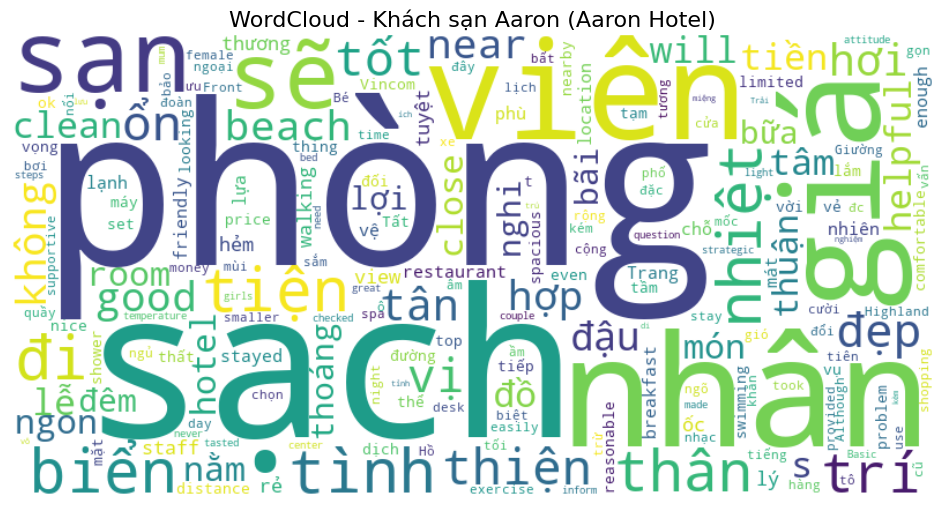

In [82]:
# T√¨m theo hotel_id
hotel_wordcloud(df3, hotel_id="1_3")

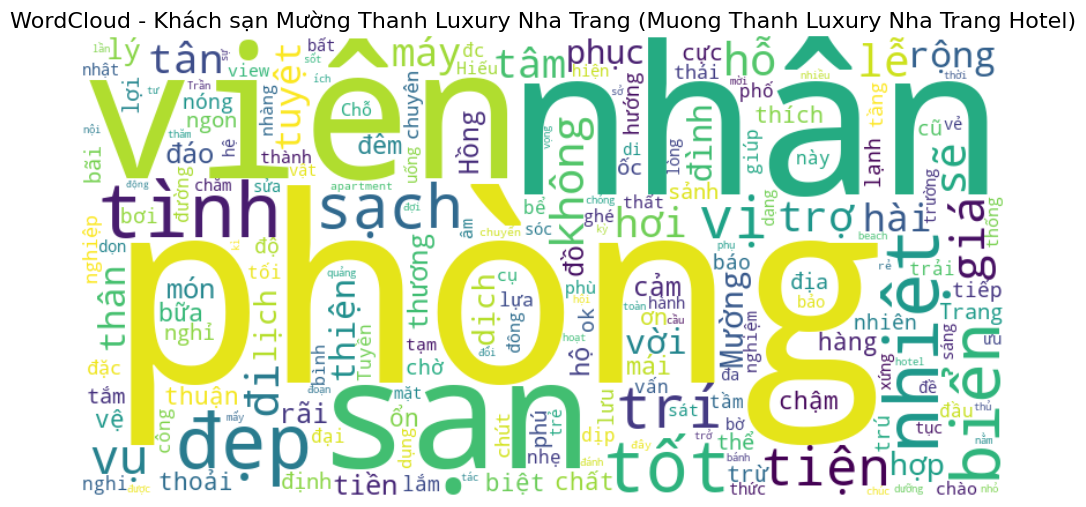

In [83]:
# T√¨m theo keyword trong t√™n kh√°ch s·∫°n
hotel_wordcloud(df3, keyword="M∆∞·ªùng Thanh")

### Content-based Filtering

##### Cosine_similarity

In [48]:
df2.columns

Index(['Hotel_ID', 'Reviewer_Name', 'Nationality', 'Group_Name', 'Room_Type',
       'Score', 'Score_Level', 'Title', 'Body', 'Review_Date', 'Hotel_Name',
       'Days', 'Month_Stay', 'Mean_Reviewer_Score', 'Review_ID_real',
       'Body_clean'],
      dtype='object')

In [49]:
df1.columns

Index(['num', 'Hotel_ID', 'Hotel_Name', 'Hotel_Address', 'Total_Score',
       'Location', 'Cleanliness', 'Service', 'Facilities', 'Value_for_money',
       'Comfort_and_room_quality', 'comments_count', 'Hotel_Description',
       'Hotel_Rank_Num'],
      dtype='object')

In [59]:
df2.columns

Index(['Hotel_ID', 'Reviewer_Name', 'Nationality', 'Group_Name', 'Room_Type',
       'Score', 'Score_Level', 'Title', 'Body', 'Review_Date', 'Hotel_Name',
       'Days', 'Month_Stay', 'Mean_Reviewer_Score', 'Review_ID_real',
       'Body_clean', 'non_vi_en'],
      dtype='object')

In [57]:
hotel_corpus = df2.groupby("Hotel_ID")["Body_clean"].apply(lambda x: " ".join(x)).reset_index()

In [58]:
hotel_corpus = hotel_corpus.merge(df1[["Hotel_ID", "Hotel_Name"]], on="Hotel_ID", how="left")
hotel_corpus = hotel_corpus.merge(df2[["Hotel_ID", "Room_Type"]], on="Hotel_ID", how="left")
hotel_corpus = hotel_corpus.merge(df1[["Hotel_ID", "Hotel_Address","Hotel_Description"]], on="Hotel_ID", how="left")

In [59]:
hotel_corpus.head(2)

Hotel_ID                                         Body_clean  \
0     10_1  th·ªùi v·∫ª nghƒ©a was similar with pictures good. ...   
1     10_1  th·ªùi v·∫ª nghƒ©a was similar with pictures good. ...   

                                          Hotel_Name    Room_Type  \
0  Bi·ªát th·ª± Valentine Nha Trang B8 (Valentine vil...  Villa ri√™ng   
1  Bi·ªát th·ª± Valentine Nha Trang B8 (Valentine vil...  Villa ri√™ng   

                      Hotel_Address  \
0  Vƒ©nh Tr∆∞·ªùng, Nha Trang, Vi·ªát Nam   
1  Vƒ©nh Tr∆∞·ªùng, Nha Trang, Vi·ªát Nam   

                                   Hotel_Description  
0  T·ªça l·∫°c t·∫°i v·ªã tr√≠ trung t√¢m th√†nh ph·ªë Nha Tra...  
1  T·ªça l·∫°c t·∫°i v·ªã tr√≠ trung t√¢m th√†nh ph·ªë Nha Tra...

In [60]:
cols_to_merge = ["Body_clean", "Hotel_Name", "Room_Type", "Hotel_Address", "Hotel_Description"]
hotel_corpus[cols_to_merge] = hotel_corpus[cols_to_merge].fillna("").astype("string")

In [61]:
hotel_corpus["Content"] = hotel_corpus[cols_to_merge].agg(" ".join, axis=1)

In [62]:
check_duplicate_column(hotel_corpus,"Content")

S·ªë d√≤ng tr√πng theo c·ªôt 'Content': 15695


Hotel_ID                                         Body_clean  \
1         10_1  th·ªùi v·∫ª nghƒ©a was similar with pictures good. ...   
4        10_12  tr√¨ ho√£n h√†nh l√Ω m√°y bay, s·∫°n 3 s√°ng, c·∫£m k√≠ch...   
6        10_12  tr√¨ ho√£n h√†nh l√Ω m√°y bay, s·∫°n 3 s√°ng, c·∫£m k√≠ch...   
7        10_12  tr√¨ ho√£n h√†nh l√Ω m√°y bay, s·∫°n 3 s√°ng, c·∫£m k√≠ch...   
9        10_12  tr√¨ ho√£n h√†nh l√Ω m√°y bay, s·∫°n 3 s√°ng, c·∫£m k√≠ch...   
...        ...                                                ...   
17505      9_7  Ph√≤ng r·ªông l·ªõn, gi√≥ m√°t ch·ªãu, m√°y l·∫°nh ƒë√™m n√≥n...   
17506      9_7  Ph√≤ng r·ªông l·ªõn, gi√≥ m√°t ch·ªãu, m√°y l·∫°nh ƒë√™m n√≥n...   
17507      9_7  Ph√≤ng r·ªông l·ªõn, gi√≥ m√°t ch·ªãu, m√°y l·∫°nh ƒë√™m n√≥n...   
17508      9_7  Ph√≤ng r·ªông l·ªõn, gi√≥ m√°t ch·ªãu, m√°y l·∫°nh ƒë√™m n√≥n...   
17509      9_7  Ph√≤ng r·ªông l·ªõn, gi√≥ m√°t ch·ªãu, m√°y l·∫°nh ƒë√™m n√≥n...   

                                              Hotel_Name  \
1      Bi·ªát th·ª± Valentine Nha Trang B8 (Valentine vil...   
4                                             Sata Hotel   
6                                             Sata Hotel   
7                                             Sata Hotel   
9                                             Sata Hotel   
...                                                  ...   
17505                          Vinpearl Resort Nha Trang   
17506                          Vinpearl Resort Nha Trang   
17507                          Vinpearl Resort Nha Trang   
17508                          Vinpearl Resort Nha Trang   
17509                          Vinpearl Resort Nha Trang   

                                      Room_Type  \
1                                   Villa ri√™ng   
4                        Deluxe h∆∞·ªõng th√†nh ph·ªë   
6                        Deluxe h∆∞·ªõng th√†nh ph·ªë   
7                Ph√≤ng Superior h∆∞·ªõng th√†nh ph·ªë   
9                Ph√≤ng Senior Deluxe h∆∞·ªõng bi·ªÉn   
...                                         ...   
17505                Ph√≤ng Lo·∫°i Sang Gi∆∞·ªùng ƒê√¥i   
17506                Ph√≤ng Lo·∫°i Sang Gi∆∞·ªùng ƒê√¥i   
17507                Ph√≤ng Lo·∫°i Sang Gi∆∞·ªùng ƒê√¥i   
17508  Ph√≤ng Grand Deluxe h∆∞·ªõng bi·ªÉn gi∆∞·ªùng ƒë√¥i   
17509                Ph√≤ng Lo·∫°i Sang Gi∆∞·ªùng ƒê√¥i   

                                           Hotel_Address  \
1                       Vƒ©nh Tr∆∞·ªùng, Nha Trang, Vi·ªát Nam   
4      24E Nguyen Thien Thuat, Tan Lap, Nha Trang, T√¢...   
6      24E Nguyen Thien Thuat, Tan Lap, Nha Trang, T√¢...   
7      24E Nguyen Thien Thuat, Tan Lap, Nha Trang, T√¢...   
9      24E Nguyen Thien Thuat, Tan Lap, Nha Trang, T√¢...   
...                                                  ...   
17505  ƒê·∫£o H√≤n Tre, Ph∆∞·ªùng Vƒ©nh Nguy√™n , H√≤n Tre, Nha...   
17506  ƒê·∫£o H√≤n Tre, Ph∆∞·ªùng Vƒ©nh Nguy√™n , H√≤n Tre, Nha...   
17507  ƒê·∫£o H√≤n Tre, Ph∆∞·ªùng Vƒ©nh Nguy√™n , H√≤n Tre, Nha...   
17508  ƒê·∫£o H√≤n Tre, Ph∆∞·ªùng Vƒ©nh Nguy√™n , H√≤n Tre, Nha...   
17509  ƒê·∫£o H√≤n Tre, Ph∆∞·ªùng Vƒ©nh Nguy√™n , H√≤n Tre, Nha...   

                                       Hotel_Description  \
1      T·ªça l·∫°c t·∫°i v·ªã tr√≠ trung t√¢m th√†nh ph·ªë Nha Tra...   
4      Kh√°m ph√° Sata Hotel - Kh√°ch s·∫°n 3 sao t·∫°i Nha ...   
6      Kh√°m ph√° Sata Hotel - Kh√°ch s·∫°n 3 sao t·∫°i Nha ...   
7      Kh√°m ph√° Sata Hotel - Kh√°ch s·∫°n 3 sao t·∫°i Nha ...   
9      Kh√°m ph√° Sata Hotel - Kh√°ch s·∫°n 3 sao t·∫°i Nha ...   
...                                                  ...   
17505  Vinpearl Resort Nha Trang - K·ª≥ ngh·ªâ tuy·ªát v·ªùi ...   
17506  Vinpearl Resort Nha Trang - K·ª≥ ngh·ªâ tuy·ªát v·ªùi ...   
17507  Vinpearl Resort Nha Trang - K·ª≥ ngh·ªâ tuy·ªát v·ªùi ...   
17508  Vinpearl Resort Nha Trang - K·ª≥ ngh·ªâ tuy·ªát v·ªùi ...   
17509  Vinpearl Resort Nha Trang - K·ª≥ ngh·ªâ tuy·ªát v·ªùi ...   

                                                 Content  
1   

In [63]:
hotel_corpus = hotel_corpus.drop_duplicates(subset=["Content"], keep="first")

In [64]:
hotel_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1815 entries, 0 to 17470
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hotel_ID           1815 non-null   object
 1   Body_clean         1815 non-null   string
 2   Hotel_Name         1815 non-null   string
 3   Room_Type          1815 non-null   string
 4   Hotel_Address      1815 non-null   string
 5   Hotel_Description  1815 non-null   string
 6   Content            1815 non-null   object
dtypes: object(2), string(5)
memory usage: 113.4+ KB


In [65]:
hotel_corpus['Content_wt'] = hotel_corpus['Content'].fillna("").astype("string")

In [66]:
hotel_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1815 entries, 0 to 17470
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Hotel_ID           1815 non-null   object
 1   Body_clean         1815 non-null   string
 2   Hotel_Name         1815 non-null   string
 3   Room_Type          1815 non-null   string
 4   Hotel_Address      1815 non-null   string
 5   Hotel_Description  1815 non-null   string
 6   Content            1815 non-null   object
 7   Content_wt         1815 non-null   string
dtypes: object(2), string(6)
memory usage: 127.6+ KB


In [67]:
# word_tokenize
hotel_corpus["Content_wt"]= hotel_corpus["Content"].apply(lambda x: tokenize(x))

In [72]:
hotel_corpus.to_csv("data_clean/hotel_corpus_cosine.csv", index=False, encoding="utf-8-sig")

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [69]:
# Vector h√≥a TF-IDF
vectorizer = TfidfVectorizer(analyzer='word')
tfidf_matrix = vectorizer.fit_transform(hotel_corpus['Content_wt'])

In [76]:
# Save model + matrix
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")
joblib.dump(tfidf_matrix, "models/tfidf_matrix.pkl")

['models/tfidf_matrix.pkl']

In [70]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [77]:
joblib.dump(cosine_sim, "models/cosine_similarity.pkl")

['models/cosine_similarity.pkl']

In [75]:
df_show = pd.DataFrame(cosine_sim)
df_show

0         1         2         3         4         5         6     \
0     1.000000  0.075295  0.075277  0.075106  0.075123  0.075153  0.075094   
1     0.075295  1.000000  0.999868  0.999874  0.999932  0.999890  0.999811   
2     0.075277  0.999868  1.000000  0.999830  0.999800  0.999821  0.999917   
3     0.075106  0.999874  0.999830  1.000000  0.999820  0.999841  0.999761   
4     0.075123  0.999932  0.999800  0.999820  1.000000  0.999836  0.999806   
...        ...       ...       ...       ...       ...       ...       ...   
1810  0.059655  0.549013  0.549121  0.549163  0.549762  0.548971  0.549727   
1811  0.059609  0.549119  0.549226  0.549283  0.549815  0.549076  0.549779   
1812  0.059625  0.549023  0.549104  0.549147  0.549747  0.548981  0.549712   
1813  0.059634  0.548819  0.548927  0.548969  0.549543  0.548777  0.549508   
1814  0.064551  0.548886  0.548967  0.549010  0.549609  0.548844  0.549574   

          7         8         9     ...      1805      1806      1807  \
0     0.075273  0.069633  0.069655  ...  0.059674  0.059629  0.059652   
1     0.999888  0.495188  0.495450  ...  0.549365  0.548629  0.549518   
2     0.999844  0.495003  0.495152  ...  0.549446  0.548710  0.549625   
3     0.999986  0.494879  0.495028  ...  0.549489  0.548753  0.549682   
4     0.999820  0.495683  0.495902  ...  0.550087  0.549353  0.550214   
...        ...       ...       ...  ...       ...       ...       ...   
1810  0.549088  0.627071  0.626888  ...  0.999474  0.999393  0.999546   
1811  0.549193  0.626815  0.626677  ...  0.999807  0.999722  0.999920   
1812  0.549071  0.627618  0.627511  ...  0.999706  0.999668  0.999776   
1813  0.548894  0.626949  0.626811  ...  0.999800  0.999744  0.999898   
1814  0.548934  0.626666  0.626558  ...  0.999461  0.999422  0.999531   

          1808      1809      1810      1811      1812      1813      1814  
0     0.059780  0.059602  0.059655  0.059609  0.059625  0.059634  0.064551  
1     0.549405  0.549055  0.549013  0.549119  0.549023  0.548819  0.548886  
2     0.549486  0.549163  0.549121  0.549226  0.549104  0.548927  0.548967  
3     0.549542  0.549219  0.549163  0.549283  0.549147  0.548969  0.549010  
4     0.550114  0.549775  0.549762  0.549815  0.549747  0.549543  0.549609  
...        ...       ...       ...       ...       ...       ...       ...  
1810  0.999097  0.999479  1.000000  0.999466  0.999366  0.999488  0.999282  
1811  0.999307  0.999987  0.999466  1.000000  0.999695  0.999978  0.999450  
1812  0.999210  0.999682  0.999366  0.999695  1.000000  0.999717  0.999395  
1813  0.999286  0.999966  0.999488  0.999978  0.999717  1.000000  0.999471  
1814  0.999125  0.999437  0.999282  0.999450  0.999395  0.999471  1.000000  

[1815 rows x 1815 columns]

In [78]:
def recommend_hotels_by_keyword(hotel_corpus, cosine_sim, keyword, top_k=5):
    # Reset index ƒë·ªÉ mapping ƒë√∫ng
    hotel_corpus = hotel_corpus.reset_index(drop=True)

    # T√¨m kh√°ch s·∫°n theo keyword (ch·ª©a trong t√™n)
    matches = hotel_corpus[hotel_corpus["Hotel_Name"].str.contains(keyword, case=False, na=False)]

    if matches.empty:
        print(f"‚ùå Kh√¥ng t√¨m th·∫•y kh√°ch s·∫°n n√†o ch·ª©a t·ª´ kh√≥a '{keyword}'")
        return pd.DataFrame()

    all_results = []

    for idx in matches.index:
        src_id = hotel_corpus.loc[idx, "Hotel_ID"]
        src_name = hotel_corpus.loc[idx, "Hotel_Name"]

        # T√≠nh similarity
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Lo·∫°i ch√≠nh n√≥
        sim_scores = [(i, score) for i, score in sim_scores if i != idx]

        # L·∫•y top-k v√† tr√°nh tr√πng hotel_id
        seen_ids = set()
        count = 0
        for i, score in sim_scores:
            hid = hotel_corpus.loc[i, "Hotel_ID"]
            if hid not in seen_ids:
                seen_ids.add(hid)
                all_results.append({
                    "Source_Hotel_ID": src_id,
                    "Source_Hotel_Name": src_name,
                    "Recommended_Hotel_ID": hid,
                    "Recommended_Hotel_Name": hotel_corpus.loc[i, "Hotel_Name"],
                    "Recommended_Hotel_Address": hotel_corpus.loc[i, "Hotel_Address"],
                    "Recommended_Hotel_Description": hotel_corpus.loc[i, "Hotel_Description"],
                    "Similarity": round(score, 3)
                })
                count += 1
            if count >= top_k:
                break

    return pd.DataFrame(all_results)

In [79]:
recommend_hotels_by_keyword(hotel_corpus, cosine_sim, keyword = "M∆∞·ªùng Thanh", top_k=5)

Source_Hotel_ID                                  Source_Hotel_Name  \
0               1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
1               1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
2               1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
3               1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
4               1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
..              ...                                                ...   
105           40_15  CƒÉn h·ªô 68 m¬≤ 2 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
106           40_15  CƒÉn h·ªô 68 m¬≤ 2 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
107           40_15  CƒÉn h·ªô 68 m¬≤ 2 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
108           40_15  CƒÉn h·ªô 68 m¬≤ 2 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   
109           40_15  CƒÉn h·ªô 68 m¬≤ 2 ph√≤ng ng·ªß, 2 ph√≤ng t·∫Øm ri√™ng ·ªü ...   

    Recommended_Hotel_ID                             Recommended_Hotel_Name  \
0                    1_1  Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang (Muong ...   
1                   3_10         Kh√°ch s·∫°n Dendro Gold (Dendro Gold Hotel )   
2                   2_11                              Maris Hotel Nha Trang   
3                   20_2    Kh√°ch S·∫°n MerPerle Beach (MerPerle Beach Hotel)   
4                   4_25                                  Diamond Bay Hotel   
..                   ...                                                ...   
105                41_22  Kh√°ch S·∫°n Nha Trang Pearl (Nha Trang Pearl Hotel)   
106                27_23  CƒÉn h·ªô M∆∞·ªùng Thanh Vi·ªÖn Tri·ªÅu Nha Trang (M∆∞·ªùng...   
107                 38_7                      Kh√°ch S·∫°n Arima (Arima Hotel)   
108                15_18                             Muong Thanh Apartments   
109                  4_8    Kh√°ch S·∫°n Boutique Em ∆†i (Em Oi Boutique Hotel)   

                             Recommended_Hotel_Address  \
0            60 Tr·∫ßn Ph√∫, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam   
1    86/4 Tran Phu Street, L·ªôc Th·ªç, Nha Trang, Vi·ªát...   
2    27 Tr·∫ßn Quang Kh·∫£i, Ph∆∞·ªùng L·ªôc Th·ªç, Th√†nh ph·ªë ...   
3    88A Tran Phu Street, L·ªôc Th·ªç, Nha Trang, Vi·ªát ...   
4            20 Tr·∫ßn Ph√∫, L·ªôc Th·ªç, Nha Trang, Vi·ªát Nam   
..                                                 ...   
105  2 Phan Boi Chau, Xuong Huan, Nha Trang City, K...   
106  3 pham van dong, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát N...   
107  96B/12 Tran Phu Street, Loc Tho Ward, L·ªôc Th·ªç,...   
108  60 Tran Phu_ T·∫ßng Tr·ªát, L·ªôc Th·ªç, Nha Trang, Vi...   
109  60 Phan Chu Trinh, X∆∞∆°ng Hu√¢n, Nha Trang, Vi·ªát...   

                         Recommended_Hotel_Description  Similarity  
0    Kh√°ch s·∫°n M∆∞·ªùng Thanh Luxury Nha Trang - N∆°i l...       1.000  
1    Kh√°ch s·∫°n Dendro Gold - K·ª≥ ngh·ªâ th√∫ v·ªã t·∫°i Nha...       0.824  
2    Maris Hotel Nha Trang - N∆°i l∆∞u tr√∫ ƒë·∫≥ng c·∫•p t...       0.812  
3    Kh√°ch S·∫°n MerPerle Beach - N∆°i L√Ω T∆∞·ªüng Cho K·ª≥...       0.810  
4    Diamond Bay Hotel - N∆°i l∆∞u tr√∫ sang tr·ªçng t·∫°i...       0.802  
..                                                 ...         ...  
105  Kh√°ch S·∫°n Nha Trang Pearl - N∆°i L∆∞u Tr√∫ L√Ω T∆∞·ªü...       0.665  
106  CƒÉn h·ªô M∆∞·ªùng Thanh Vi·ªÖn Tri·ªÅu Nha Trang - N∆°i ...       0.638  
107  Kh√°ch S·∫°n Arima - N∆°i L∆∞u Tr√∫ L√Ω T∆∞·ªüng T·∫°i Nha...       0.629  
108  Muong Thanh Apartments - N∆°i l∆∞u tr√∫ l√Ω t∆∞·ªüng ...       0.625  
109  Kh√°ch S·∫°n Boutique Em ∆†i - N∆°i l∆∞u gi·ªØ h·ªìi ·ª©c ...       0.623  

[110 rows x 7 columns]

##### Gensim

In [71]:
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_punctuation

In [72]:
hotel_corpus2 = hotel_corpus

In [73]:
hotel_corpus2 = hotel_corpus2.reset_index(drop=False)  
hotel_corpus2 = hotel_corpus2.rename(columns={'index':'original_index'})

In [74]:
hotel_corpus2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_index     1815 non-null   int64 
 1   Hotel_ID           1815 non-null   object
 2   Body_clean         1815 non-null   string
 3   Hotel_Name         1815 non-null   string
 4   Room_Type          1815 non-null   string
 5   Hotel_Address      1815 non-null   string
 6   Hotel_Description  1815 non-null   string
 7   Content            1815 non-null   object
 8   Content_wt         1815 non-null   object
dtypes: int64(1), object(3), string(5)
memory usage: 127.7+ KB


In [75]:
processed_docs = [
    preprocess_string(doc, filters=[strip_punctuation, remove_stopwords]) 
    for doc in hotel_corpus2['Content_wt'].tolist()
]

In [76]:
# 2. T·∫°o dictionary v√† corpus
dictionary = corpora.Dictionary(processed_docs)
corpus_gensim = [dictionary.doc2bow(doc) for doc in processed_docs]

In [118]:
corpora.MmCorpus.serialize("models/corpus_gensim.mm", corpus_gensim)

In [105]:
dictionary.save("models/dictionary.dict")

In [77]:
# 3. TF-IDF model
tfidf = models.TfidfModel(corpus_gensim)
corpus_tfidf = tfidf[corpus_gensim]

In [107]:
tfidf.save("models/tfidf_gensim.model")

In [78]:
# 4. Similarity index
index = similarities.SparseMatrixSimilarity(corpus_tfidf, num_features=len(dictionary))

In [109]:
index.save("models/similarity_index.index")

In [79]:
df_1 = pd.DataFrame(index)
df_1

0         1         2         3         4         5         6     \
0     1.000000  0.004194  0.004194  0.004192  0.004194  0.004192  0.004192   
1     0.004194  1.000000  0.999974  0.999881  0.999989  0.999434  0.999435   
2     0.004194  0.999974  0.999999  0.999910  0.999965  0.999453  0.999455   
3     0.004192  0.999881  0.999910  1.000003  0.999873  0.999360  0.999362   
4     0.004194  0.999989  0.999965  0.999873  1.000002  0.999431  0.999433   
...        ...       ...       ...       ...       ...       ...       ...   
1810  0.008050  0.040434  0.040523  0.040503  0.040500  0.040401  0.040924   
1811  0.008050  0.040556  0.040644  0.040624  0.040592  0.040506  0.041028   
1812  0.008060  0.040663  0.040742  0.040722  0.040717  0.040630  0.041153   
1813  0.008050  0.040439  0.040527  0.040507  0.040493  0.040406  0.040929   
1814  0.012348  0.040442  0.040521  0.040501  0.040496  0.040409  0.040931   

          7         8         9     ...      1805      1806      1807  \
0     0.004192  0.000749  0.000750  ...  0.008040  0.008020  0.008071   
1     0.999881  0.039368  0.039769  ...  0.040336  0.040235  0.040544   
2     0.999910  0.039280  0.039561  ...  0.040414  0.040314  0.040632   
3     1.000003  0.039261  0.039541  ...  0.040395  0.040294  0.040612   
4     0.999873  0.039415  0.039798  ...  0.040389  0.040289  0.040598   
...        ...       ...       ...  ...       ...       ...       ...   
1810  0.040504  0.054405  0.054435  ...  0.997860  0.998190  0.999492   
1811  0.040625  0.054332  0.054391  ...  0.997856  0.998186  0.999488   
1812  0.040724  0.054377  0.054440  ...  0.997799  0.998133  0.999408   
1813  0.040509  0.054291  0.054351  ...  0.997872  0.998199  0.999503   
1814  0.040503  0.054104  0.054168  ...  0.996764  0.997091  0.998378   

          1808      1809      1810      1811      1812      1813      1814  
0     0.012406  0.008049  0.008050  0.008050  0.008060  0.008050  0.012348  
1     0.040613  0.040552  0.040434  0.040556  0.040663  0.040439  0.040442  
2     0.040692  0.040640  0.040523  0.040644  0.040742  0.040527  0.040521  
3     0.040672  0.040620  0.040503  0.040624  0.040722  0.040507  0.040501  
4     0.040650  0.040600  0.040500  0.040592  0.040717  0.040493  0.040496  
...        ...       ...       ...       ...       ...       ...       ...  
1810  0.999365  0.999984  1.000000  0.999976  0.999286  0.999989  0.998249  
1811  0.999389  0.999989  0.999976  1.000001  0.999281  0.999985  0.998244  
1812  0.999300  0.999271  0.999286  0.999281  0.999999  0.999294  0.998188  
1813  0.999374  0.999977  0.999989  0.999985  0.999294  1.000001  0.998259  
1814  0.998799  0.998234  0.998249  0.998244  0.998188  0.998259  0.999999  

[1815 rows x 1815 columns]

In [80]:
hotel_corpus2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_index     1815 non-null   int64 
 1   Hotel_ID           1815 non-null   object
 2   Body_clean         1815 non-null   string
 3   Hotel_Name         1815 non-null   string
 4   Room_Type          1815 non-null   string
 5   Hotel_Address      1815 non-null   string
 6   Hotel_Description  1815 non-null   string
 7   Content            1815 non-null   object
 8   Content_wt         1815 non-null   object
dtypes: int64(1), object(3), string(5)
memory usage: 127.7+ KB


In [81]:
hotel_corpus2.to_csv("data_clean/hotel_corpus_gensim.csv", index=False, encoding="utf-8-sig")

In [112]:
def find_hotels_by_keyword(hotel_corpus2, keyword):
    """
    Tr·∫£ v·ªÅ c√°c kh√°ch s·∫°n ch·ª©a t·ª´ kh√≥a trong Hotel_Name
    """
    matches = hotel_corpus[hotel_corpus["Hotel_Name"].str.contains(keyword, case=False, na=False)]
    if matches.empty:
        print(f"‚ùå Kh√¥ng t√¨m th·∫•y kh√°ch s·∫°n n√†o ch·ª©a t·ª´ kh√≥a '{keyword}'")
        return pd.DataFrame()
    return matches

In [113]:
def get_topk_recommendations(hotel_corpus2, matches, corpus_gensim, tfidf, index, top_k=5):
    """
    hotel_corpus2: DataFrame ƒë√£ reset_index
    matches: DataFrame c√°c kh√°ch s·∫°n kh·ªõp keyword, c√≥ c·ªôt 'pos' l∆∞u v·ªã tr√≠ trong corpus_gensim
    corpus_gensim: danh s√°ch vector gensim
    tfidf: m√¥ h√¨nh tfidf
    index: gensim.Similarity index
    top_k: s·ªë k·∫øt qu·∫£ mu·ªën tr·∫£ v·ªÅ
    """
    results = []

    for _, row in matches.iterrows():
        corpus_pos = row['pos']
        query_bow = corpus_gensim[corpus_pos]
        sims = index[tfidf[query_bow]]

        # S·∫Øp x·∫øp similarity, lo·∫°i ch√≠nh n√≥
        sims_sorted = sorted(list(enumerate(sims)), key=lambda x: -x[1])
        topk = [(i, score) for i, score in sims_sorted if i != corpus_pos][:top_k]

        for i, score in topk:
            # L·∫•y th√¥ng tin kh√°ch s·∫°n recommended
            hotel_info = hotel_corpus2.iloc[i]
            results.append({
                "Source_Hotel": row["Hotel_Name"],
                "Recommended_Hotel": hotel_info["Hotel_Name"],
                "Address": hotel_info.get("Hotel_Address", ""),
                "Description": hotel_info.get("Hotel_Description", ""),
                "Score": score
            })

    return pd.DataFrame(results)


In [114]:
keyword = "Oasis Retreat"
matches = hotel_corpus2[hotel_corpus2['Hotel_Name'].str.contains(keyword, case=False)].copy()
matches['pos'] = matches.index

In [121]:
matches

original_index Hotel_ID  \
203            2660     13_3   
204            2663     13_3   
929           12927     2_10   
930           12928     2_10   
931           12931     2_10   
932           12934     2_10   
933           12946     2_10   

                                            Body_clean  \
203  ok, gi√° h·ª£p l√Ω 3 pn, gi√° ti·ªÅn ph√π h·ª£p ƒë√¨nh nh·∫Ø...   
204  ok, gi√° h·ª£p l√Ω 3 pn, gi√° ti·ªÅn ph√π h·ª£p ƒë√¨nh nh·∫Ø...   
929  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
930  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
931  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
932  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
933  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   

                                       Hotel_Name  \
203        Oasis Retreat - Muong Thanh Vien Trieu   
204        Oasis Retreat - Muong Thanh Vien Trieu   
929  Oceanus Oasis Retreat Muong Thanh Vien Trieu   
930  Oceanus Oasis Retreat Muong Thanh Vien Trieu   
931  Oceanus Oasis Retreat Muong Thanh Vien Trieu   
932  Oceanus Oasis Retreat Muong Thanh Vien Trieu   
933  Oceanus Oasis Retreat Muong Thanh Vien Trieu   

                         Room_Type  \
203             CƒÉn h·ªô 3 ph√≤ng ng·ªß   
204                  CƒÉn h·ªô Deluxe   
929             CƒÉn H·ªô 2 Ph√≤ng Ng·ªß   
930             CƒÉn h·ªô 3 ph√≤ng ng·ªß   
931        Ph√≤ng Superior gia ƒë√¨nh   
932  CƒÉn h·ªô 2 ph√≤ng ng·ªß h∆∞·ªõng bi·ªÉn   
933                CƒÉn h·ªô Superior   

                                         Hotel_Address  \
203  3 Pham Van Dong, OC 1 B Muong Thanh Vien Trieu...   
204  3 Pham Van Dong, OC 1 B Muong Thanh Vien Trieu...   
929  Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam...   
930  Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam...   
931  Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam...   
932  Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam...   
933  Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam...   

                                     Hotel_Description  \
203  Oasis Retreat - Muong Thanh Vien Trieu

L√†m ch...   
204  Oasis Retreat - Muong Thanh Vien Trieu

L√†m ch...   
929  Oceanus Oasis Retreat Muong Thanh Vien Trieu -...   
930  Oceanus Oasis Retreat Muong Thanh Vien Trieu -...   
931  Oceanus Oasis Retreat Muong Thanh Vien Trieu -...   
932  Oceanus Oasis Retreat Muong Thanh Vien Trieu -...   
933  Oceanus Oasis Retreat Muong Thanh Vien Trieu -...   

                                               Content  \
203  ok, gi√° h·ª£p l√Ω 3 pn, gi√° ti·ªÅn ph√π h·ª£p ƒë√¨nh nh·∫Ø...   
204  ok, gi√° h·ª£p l√Ω 3 pn, gi√° ti·ªÅn ph√π h·ª£p ƒë√¨nh nh·∫Ø...   
929  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
930  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
931  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
932  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   
933  l∆∞u tr√∫ tuy·ªát v·ªùi Trang. c·∫°nh b√£i bi·ªÉn, ƒëi b∆°i...   

                                            Content_wt  pos  
203  ok , gi√° h·ª£p_l√Ω 3 pn , gi√° ti·ªÅn ph√π_h·ª£p ƒë√¨nh n...  203  
204  ok , gi√° h·ª£p_l√Ω 3 pn , gi√° ti·ªÅn ph√π_h·ª£p ƒë√¨nh n...  204  
929  l∆∞u_tr√∫ tuy·ªát_v·ªùi Trang . c·∫°nh b√£i bi·ªÉn , ƒëi b...  929  
930  l∆∞u_tr√∫ tuy·ªát_v·ªùi Trang . c·∫°nh b√£i bi·ªÉn , ƒëi b...  930  
931  l∆∞u_tr√∫ tuy·ªát_v·ªùi Trang . c·∫°nh b√£i bi·ªÉn , ƒëi b...  931  
932  l∆∞u_tr√∫ tuy·ªát_v·ªùi Trang . c·∫°nh b√£i bi·ªÉn , ƒëi b...  932  
933  l∆∞u_tr√∫ tuy·ªát_v·ªùi Trang . c·∫°nh b√£i bi·ªÉn , ƒëi b...  933

In [115]:
df_results = get_topk_recommendations(hotel_corpus2, matches, corpus_gensim, tfidf, index, top_k=5)


In [116]:
df_results = df_results.drop_duplicates(subset="Recommended_Hotel", keep="first").reset_index(drop=True).sort_values(by="Score", ascending=False).reset_index(drop=True)
df_results

Source_Hotel  \
0        Oasis Retreat - Muong Thanh Vien Trieu   
1  Oceanus Oasis Retreat Muong Thanh Vien Trieu   
2        Oasis Retreat - Muong Thanh Vien Trieu   
3        Oasis Retreat - Muong Thanh Vien Trieu   
4        Oasis Retreat - Muong Thanh Vien Trieu   

                              Recommended_Hotel  \
0        Oasis Retreat - Muong Thanh Vien Trieu   
1  Oceanus Oasis Retreat Muong Thanh Vien Trieu   
2    Muong Thanh Beachfront Apartment Nha Trang   
3       HANZ Condo Hotel Muong Thanh Vien Trieu   
4       HANZ Muong Thanh Vien Trieu Condo Hotel   

                                             Address  \
0  3 Pham Van Dong, OC 1 B Muong Thanh Vien Trieu...   
1  Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh Ph∆∞·ªõc, Nha Trang, Vi·ªát Nam...   
2  03 Ph·∫°m VƒÉn ƒê·ªìng, T√≤a Nh√† OC2B - M∆∞·ªùng Thanh V...   
3  5 Ph·∫°m VƒÉn ƒê·ªìng, Muong Thanh Vien Trieu, Nha T...   
4  5 Ph·∫°m VƒÉn ƒê·ªìng, Vƒ©nh H·∫£i, Nha Trang, Kh√°nh H√≤...   

                                         Description     Score  
0  Oasis Retreat - Muong Thanh Vien Trieu\n\nL√†m ...  0.999960  
1  Oceanus Oasis Retreat Muong Thanh Vien Trieu -...  0.999266  
2  Muong Thanh Beachfront Apartment Nha Trang\n\n...  0.605492  
3  HANZ Condo Hotel Muong Thanh Vien Trieu\n\nTh·ª©...  0.477637  
4  HANZ Muong Thanh Vien Trieu Condo Hotel\n\nT·∫≠n...  0.407900